#0: 前処理

## 0.1: googledriveをマウント

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##0.2: インポート

In [2]:
from tqdm import tqdm
import time
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
import datetime
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from itertools import combinations
from itertools import permutations
from urllib.request import urlopen

## 0.3: pickleファイルの読み込み

pickleファイルの保存方法

  * [ DataFrameの名前 ].to_pickle('[ path名 ]')

In [ ]:
# 1レース当たりの全体データ(index: race_id)
# race_results : 生データ
# race_results_p : preprocessingに通した後のデータ
# race_results_d : ダミー変数化したデータ
# race_results_r : 着順→rankに変更したデータ
#
# 1頭あたりの馬データ(index: horse_id)
# horse_results : 生データ
#
# 血統データ
# ped_results
#
# return_tables : 出馬表のデータ
#
# 総合的データ
# results_m : race_resultsとhorse_resultsのmerge後のデータ
# results_5R : 過去5R分の着順並びに賞金のデータを加えたデータ
#

In [183]:
# 全体のデータを取得する。
race_results=pd.read_pickle('drive/My Drive/Horse_racing/pickle/overall/race_results.pickle')
horse_results=pd.read_pickle('drive/My Drive/Horse_racing/pickle/overall/horse_results.pickle')
ped_results=pd.read_pickle('drive/My Drive/Horse_racing/pickle/overall/ped_results.pickle')
return_tables=pd.read_pickle('drive/My Drive/Horse_racing/pickle/overall/return_tables.pickle')
horse_id_list = race_results['horse_id'].unique()

In [ ]:
# 2021年のデータを取得する。
race_results_2021 = pd.read_pickle('drive/My Drive/Horse_racing/pickle/2021/race_results.pickle')
horse_results_2021=pd.read_pickle('drive/My Drive/Horse_racing/pickle/2021/horse_results.pickle')
return_tables_2021=pd.read_pickle('drive/My Drive/Horse_racing/pickle/2021/return_tables.pickle')
ped_results_2021=pd.read_pickle('drive/My Drive/Horse_racing/pickle/2021/ped_results.pickle')
horse_id_list_2021 = race_results_2021['horse_id'].unique()

In [ ]:
# 2020年のデータを取得する。
race_results_2020 = pd.read_pickle('drive/My Drive/Horse_racing/pickle/2020/race_results.pickle')
horse_results_2020=pd.read_pickle('drive/My Drive/Horse_racing/pickle/2020/horse_results.pickle')
return_tables_2020=pd.read_pickle('drive/My Drive/Horse_racing/pickle/2020/return_tables.pickle')
ped_results_2020=pd.read_pickle('drive/My Drive/Horse_racing/pickle/2020/ped_results.pickle')
horse_id_list_2020 = race_results_2020['horse_id'].unique()

In [ ]:
# 2019年のデータを取得する。
race_results_2019=pd.read_pickle('drive/My Drive/Horse_racing/pickle/2019/race_results.pickle')
horse_results_2019=pd.read_pickle('drive/My Drive/Horse_racing/pickle/2019/horse_results.pickle')
return_tables_2019=pd.read_pickle('drive/My Drive/Horse_racing/pickle/2019/return_tables.pickle')
ped_results_2019=pd.read_pickle('drive/My Drive/Horse_racing/pickle/2019/ped_results.pickle')
horse_id_list_2019 = race_results_2019['horse_id'].unique()

In [ ]:
# 2018年のデータを取得する。
race_results_2018=pd.read_pickle('drive/My Drive/Horse_racing/pickle/2018/race_results.pickle')
horse_results_2018=pd.read_pickle('drive/My Drive/Horse_racing/pickle/2018/horse_results.pickle')
return_tables_2018=pd.read_pickle('drive/My Drive/Horse_racing/pickle/2018/return_tables.pickle')
ped_results_2018=pd.read_pickle('drive/My Drive/Horse_racing/pickle/2018/ped_results.pickle')
horse_id_list_2018 = race_results_2018['horse_id'].unique()

In [ ]:
# 2017年のデータを取得する。
race_results_2017=pd.read_pickle('drive/My Drive/Horse_racing/pickle/2017/race_results.pickle')
horse_results_2017=pd.read_pickle('drive/My Drive/Horse_racing/pickle/2017/horse_results.pickle')
return_tables_2017=pd.read_pickle('drive/My Drive/Horse_racing/pickle/2017/return_tables.pickle')
ped_results_2017=pd.read_pickle('drive/My Drive/Horse_racing/pickle/2017/ped_results.pickle')
horse_id_list_2017 = race_results_2017['horse_id'].unique()

In [4]:
#開催場所をidに変換するための辞書型
place_dict = {
    '札幌':'01',  '函館':'02',  '福島':'03',  '新潟':'04',  '東京':'05', 
    '中山':'06',  '中京':'07',  '京都':'08',  '阪神':'09',  '小倉':'10'
}

#レースタイプをレース結果データと整合させるための辞書型
race_type_dict = {
    '芝': '芝', 'ダ': 'ダート', '障': '障害'
}

# 1: クラス定義

## 1.1:  DataProcessorクラス

In [215]:
class DataProcessor:

  """    
  Attributes:
  ----------
  data : pd.DataFrame
      rawデータ
  data_p : pd.DataFrame
      preprocessing後のデータ
  data_h : pd.DataFrame
      merge_horse_results後のデータ
  data_pe : pd.DataFrame
      merge_peds後のデータ
  data_c : pd.DataFrame
      process_categorical後のデータ
  no_peds: Numpy.array
      merge_pedsを実行した時に、血統データが存在しなかった馬のhorse_id一覧
  """


  def __init__(self):
    self.data = pd.DataFrame()
    self.data_p = pd.DataFrame()
    self.data_h = pd.DataFrame()
    self.data_pe = pd.DataFrame()
    self.data_c = pd.DataFrame()

  # shutuba_tables_pに過去データを追記する。
  def merge_horse_results(self, hr, n_samples_list=[5, 9, 'all']):

    """
    馬の過去成績データから、
    n_samples_listで指定されたレース分の着順と賞金の平均を追加してdata_hに返す
    Parameters:
    ----------
    hr : HorseResults
        馬の過去成績データ
    n_samples_list : list, default [5, 9, 'all']
        過去何レース分追加するか
    """

    self.data_h = self.data_p.copy()
    for n_samples in n_samples_list:
      self.data_h = hr.merge_all(self.data_h, n_samples=n_samples)
    
    # 馬の出走間隔
    self.data_h['interval'] = (self.data_h['date'] - self.data_h['latest']).dt.days
    self.data_h.drop(['開催', 'latest'], axis=1, inplace=True)
  
  # pedデータを追記する。
  def merge_ped_results(self, ped_results):

    """
    5世代分血統データを追加してdata_peに返す
    Parameters:
    ----------
    peds : Peds.peds_e
        Pedsクラスで加工された血統データ。
    """

    self.data_pe = self.data_h.merge(ped_results, left_on='horse_id', right_index=True, how='left')

    self.no_peds = self.data_pe[self.data_pe['peds_0'].isnull()]['horse_id'].unique()
    if len(self.no_peds) > 0:
      print('please scrape ped_results at horse_id_list "no_peds"')
  
  # カテゴリ変数の処理
  def process_categorical(self, results_m):
    self.le_horse = LabelEncoder().fit(self.data_pe['horse_id'])
    self.le_jockey = LabelEncoder().fit(self.data_pe['jockey_id'])

    """
    カテゴリ変数を処理してdata_cに返す
    Parameters:
    ----------
    le_horse : sklearn.preprocessing.LabelEncoder
        horse_idを0始まりの整数に変換するLabelEncoderオブジェクト。
    le_jockey : sklearn.preprocessing.LabelEncoder
        jockey_idを0始まりの整数に変換するLabelEncoderオブジェクト。
    results_m : Results.data_pe
        ダミー変数化のとき、ResultsクラスとShutubaTableクラスで列を合わせるためのもの
    """

    df = self.data_pe.copy()

    # ラベルエンコーディング: horse_id, jockey_idを0始まりの整数に変換
    # classes_: fit()によって各ラベルがどのラベルIDと対応づけられたのかを取得可能
    # mask関数: 引数リストの中身がTrueのところをNaNにし、Falseのところには実データを入れる
    # where関数: 引数リストの中身がTrueのところを実データにし、FalseのところにはNaNを入れる
    mask_horse = df['horse_id'].isin(self.le_horse.classes_)
    new_horse_id = df['horse_id'].mask(mask_horse).dropna().unique()
    self.le_horse.classes_ = np.concatenate([self.le_horse.classes_, new_horse_id])
    df['horse_id'] = self.le_horse.transform(df['horse_id'])
    mask_jockey = df['jockey_id'].isin(self.le_jockey.classes_)
    new_jockey_id = df['jockey_id'].mask(mask_jockey).dropna().unique()
    self.le_jockey.classes_ = np.concatenate([self.le_jockey.classes_, new_jockey_id])
    df['jockey_id'] = self.le_jockey.transform(df['jockey_id'])

    # horse_id, jockey_idをpandasのcategory型に変換
    df['horse_id'] = df['horse_id'].astype('category')
    df['jockey_id'] = df['jockey_id'].astype('category')

    # その他のカテゴリ変数をpandasのcategory型に変換してからダミー変数化
    # 列を一定にするため
    weathers = results_m['weather'].unique()
    race_types = results_m['race_type'].unique()
    ground_states = results_m['ground_state'].unique()
    sexes = results_m['性'].unique()

    # pd.Categorical関数: get_dummies関数にかける前に列を指定できる。要するに、全て0の列を作成可能。
    df['weather'] = pd.Categorical(df['weather'], weathers)
    df['race_type'] = pd.Categorical(df['race_type'], race_types)
    df['ground_state'] = pd.Categorical(df['ground_state'], ground_states)
    df['性'] = pd.Categorical(df['性'], sexes)
    df = pd.get_dummies(df, columns=['weather', 'race_type', 'ground_state', '性'])

    self.data_c = df

## 1.2: RaceResultsクラス

〜関数一覧〜
0.   \_\_init\_\_(self, race_results)
  *  scrape()で取得したrace_resultsをclass内に格納する。

1.   scrape(race_id_list, pre_race_results)
  * @staticmethod(静的なメソッド。classをわざわざインスタンス化しなくても関数として実行可能。引数の1つ目がselfでないことに注意。)
  * race_id_list: list に含まれているレースの情報をスクレイピングする関数
  * race_id 1つにつき1レース
  * pre_race_resultsにpd.DataFrameを入れると続きから格納することも可能。
  * race_results.index = race_id_list
  * race_results.columns
  
      =['着順', '枠番', '馬番', '馬名', '性齢', '斤量', '騎手', 'タイム', '着差', '単勝', '人気',
       '馬体重', '調教師', 'course_len', 'weather', 'race_type', 'ground_state',
       'date', 'horse_id', 'jockey_id']

2.  preprocessing(self)

  * self.race_resultsに対して前処理を行う関数
  * 具体的には、

     i) 着順データに含まれている文字列データを取り除く

     ii) 性齢データを性データと年齢データに分割

     iii) 馬体重データを体重データと体重変化データに分割

     iv) dateデータのフォーマットを変更

     v) 不必要なデータをドロップ 
  * self.race_resultsに格納し直す。
  * race_results_p.index = race_id_list
  * race_results_p.columns
  
      =['着順', '枠番', '馬番', '斤量', '単勝', '人気', 'course_len', 'weather',
       'race_type', 'ground_state', 'date', 'horse_id', 'jockey_id', '性', '年齢',
       '体重', '体重変化']

3. to_rank(self)
   * self.race_resultsの着順データをrankデータに変更する関数
   * ここでのrankデータとは着順データの「4位以下」のデータを4に統一したもの
  * self.race_resultsに格納し直す。




In [210]:
# レースに関するクラス
class RaceResults(DataProcessor):

  def __init__(self, race_results):
    super(RaceResults, self).__init__()
    self.data = race_results

  @classmethod
  def read_pickle(cls, path_list):
    df = pd.read_pickle(path_list[0])
    for path in path_list[1:]:
      df = update_data(df, pd.read_pickle(path))
    return cls(df)

  @staticmethod
  def scrape(race_id_list, pre_race_results=pd.DataFrame()):

    """
    レース結果データをスクレイピングする関数
    Parameters:
    ----------
    race_id_list : list
        レースIDのリスト
    Returns:
    ----------
    race_results_df : pandas.DataFrame
        全レース結果データをまとめてDataFrame型にしたもの
    """

    #race_idをkeyにしてDataFrame型を格納
    race_results = {}
    for race_id in tqdm(race_id_list):
      R = int(race_id) % 100
      day = (int(race_id) % 10000 - R)//100
      kai = (int(race_id) % 1000000  - R - 100 * day) // 10000
      place = (int(race_id) % 100000000  - R - 100 * day  - 10000 * kai) // 1000000

      # print(R+12*(day-1)+144*(kai-1)+1728*(place-1))
      # if R+12*(day-1)+144*(kai-1)+1728*(place-1) == 10000:
      #   break
        
      if len(pre_race_results) and int(race_id) <= int(pre_race_results.index[-1]):
        continue
      try:
        time.sleep(1)
        url = "https://db.netkeiba.com/race/" + race_id
        #メインとなるテーブルデータを取得
        df = pd.read_html(url)[0]

        html = requests.get(url)
        html.encoding = "EUC-JP"
        soup = BeautifulSoup(html.text, "html.parser")

        #天候、レースの種類、コースの長さ、馬場の状態、日付をスクレイピング
        texts = (
            soup.find("div", attrs={"class": "data_intro"}).find_all("p")[0].text
            + soup.find("div", attrs={"class": "data_intro"}).find_all("p")[1].text
        )
        info = re.findall(r'\w+', texts)
        for text in info:
            if text in ["芝", "ダート"]:
                df["race_type"] = [text] * len(df)
            if "障" in text:
                df["race_type"] = ["障害"] * len(df)
            if "m" in text:
                df["course_len"] = [int(re.findall(r"\d+", text)[0])] * len(df)
            if text in ["良", "稍重", "重", "不良"]:
                df["ground_state"] = [text] * len(df)
            if text in ["曇", "晴", "雨", "小雨", "小雪", "雪"]:
                df["weather"] = [text] * len(df)
            if "年" in text:
                df["date"] = [text] * len(df)

        #馬ID、騎手IDをスクレイピング
        horse_id_list = []
        horse_a_list = soup.find("table", attrs={"summary": "レース結果"}).find_all(
            "a", attrs={"href": re.compile("^/horse")}
        )
        for a in horse_a_list:
            horse_id = re.findall(r"\d+", a["href"])
            horse_id_list.append(horse_id[0])
        jockey_id_list = []
        jockey_a_list = soup.find("table", attrs={"summary": "レース結果"}).find_all(
            "a", attrs={"href": re.compile("^/jockey")}
        )
        for a in jockey_a_list:
            jockey_id = re.findall(r"\d+", a["href"])
            jockey_id_list.append(jockey_id[0])
        df["horse_id"] = horse_id_list
        df["jockey_id"] = jockey_id_list

        #インデックスをrace_idにする
        df.index = [race_id] * len(df)

        race_results[race_id] = df

      #存在しないrace_idを飛ばす
      except IndexError:
          continue
      #wifiの接続が切れた時などでも途中までのデータを返せるようにする
      except Exception as e:
          print(e)
          break
      #Jupyterで停止ボタンを押した時の対処
      except:
          break
  
    #pd.DataFrame型にして一つのデータにまとめる
    race_results_df = pd.concat([race_results[key] for key in race_results])

    if len(pre_race_results.index):
      return pd.concat([pre_race_results, race_results_df])
    else:
      return race_results_df
  
  # 前処理
  def preprocessing(self):
    df = self.data.copy()

    # 着順に数字以外のものが含まれているデータを取り除く
    df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
    df.dropna(subset=['着順'], inplace=True)
    df['着順'] = df['着順'].astype(int)
    df['rank'] = df['着順'].map(lambda x: 1 if x<4 else 0)

    # 性齢を性と年齢に分割
    df['性'] = df['性齢'].map(lambda x: str(x)[0])
    df['年齢'] = df['性齢'].map(lambda x: str(x)[1]).astype(int)

    # 馬体重を現体重と増減に分割
    # expand:Falseなら1列に分割後の配列が格納される
    df['体重'] = df['馬体重'].str.split("(", expand=True)[0].astype(int)
    df['体重変化'] = df['馬体重'].str.split("(", expand=True)[1].str[:-1].astype(int)

    df['単勝'] = df['単勝'].astype(float)
    df["course_len"] = df["course_len"].astype(float) // 100

    df['date'] = pd.to_datetime(df['date'], format='%Y年%m月%d日')

    # 開催地
    df['開催'] = df.index.map(lambda x:str(x)[4:6])

    # 出走数
    df['n_horses'] = df.index.map(df.index.value_counts())

    # 不要な列を削除する
    # inplace:dfを置き換える
    df.drop(['タイム', '着差', '調教師', '性齢', '馬体重', '馬名', '騎手', '人気', '着順'], axis='columns', inplace=True)

    self.data_p = df
  
  def to_rank(self):
    df = self.data.copy()
    df['rank'] = df['着順'].map(lambda x: x if x<4 else 4)
    df.drop(['着順'], axis='columns', inplace=True)
    self.data = df
  
  # def process_categorical(self):
  #   self.le_horse = LabelEncoder().fit(self.data_pe['horse_id'])
  #   self.le_jockey = LabelEncoder().fit(self.data_pe['jockey_id'])
  #   super().process_categorical(self.le_horse, self.le_jockey, self.data_pe)

In [8]:
# new_race_results.to_pickle('drive/My Drive/Horse_racing/pickle/2017/race_results.pickle')

In [9]:
# # RaceResultsのスクレイピング(永久保存)

# race_id_list = []
# for place in range(1, 11, 1):
#     for kai in range(1, 13, 1):
#         for day in range(1, 13, 1):
#             for r in range(1, 13, 1):
#                 race_id = "2017" + str(place).zfill(2) + str(kai).zfill(2) + str(day).zfill(2) + str(r).zfill(2)
#                 race_id_list.append(race_id)
		
# new_race_results = RaceResults.scrape(race_id_list, pre_race_results)
# pre_race_results = new_race_results

In [10]:
# pre_race_results.to_pickle('drive/My Drive/Horse_racing/pickle/2017/race_results.pickle')

## 1.3: HorseResultsクラス

〜関数一覧〜
0.   \_\_init\_\_(self, horse_results)
  *  scrape()で取得したhorse_resultsの[ 日付, 着順, 賞金 ]データをclass内に格納する。
  * preprocessing()を実行して、前処理を行う。


1.   scrape(horse_id_list, pre_horse_results)
  * @staticmethod
  * horse_id_list: list に含まれている馬の戦績データをスクレイピングする関数
  * horse_id 1つにつき1頭
  * horse_results.index = horse_id_list
  * horse_results.columns 
  
      = ['日付', '開催', '天気', 'R', 'レース名', '映像', '頭数', '枠番', '馬番', 'オッズ', '人気',
       '着順', '騎手', '斤量', '距離', '馬場', '馬場指数', 'タイム', '着差', 'ﾀｲﾑ指数', '通過', 'ペース',
       '上り', '馬体重', '厩舎ｺﾒﾝﾄ', '備考', '勝ち馬(2着馬)', '賞金']


2.  preprocessing(self)

  * self.horse_resultsに対して前処理を行う関数
  * 具体的には、

     i) 着順データに含まれている文字列データを取り除く

     ii) 日付データのフォーマットを変更

     iii) 賞金データの欠損値を0で埋める
  * horse_results_p.index = horse_id_list
  * horse_results_p.columns = ['着順', '賞金', 'date']


3. average(self, horse_id_list, date, n_samples)
   * horse_idに対して、dateより過去のデータn_samples件の賞金データと着順データの平均値をself.horse_resultsを用いて計算する。
   * n_samples = allの場合、n_samplesの制約がない。即ち、過去データ全てを用いて平均値を計算する。


4. merge(self, results, date, n_samples)
   * resultsのdateと一致している部分DataFrameと、self.average()の返り値をmergeさせる関数。
   * resultsはrace_resultsを想定している。
   * 関数の流れは以下の通り
    1.   "date"データがdateに絞られた部分DataFrameをdfに格納する。
    2.   上記のdfに含まれるすべてのhorse_idを格納したhorse_id_listを作成する。
    3.   dfとaverage(horse_id_list, date, n_samples)をmergeする。
    4.   即ち、dfに含まれている date に行われたレースの horse_id の馬データに対して過去5回の獲得平均賞金並びに平均着順のデータを付け加える。


5. merge_all(self, results, n_samples)
  * 上記のmerge関数をresultsに含まれる全てのdateデータに対して行う。
  * n_samples = 5の場合、resultsに新たな列、賞金_5R, 着順_5Rが加えられる。



In [11]:
# 馬に関するクラス
class HorseResults:

  def __init__(self, horse_results):
    self.horse_results = horse_results[['日付', '着順', '賞金', '着差', '通過', '開催', '距離']]
    self.preprocessing()
  
  @classmethod
  def read_pickle(cls, path_list):
    df = pd.read_pickle(path_list[0])
    for path in path_list[1:]:
      df = update_data(df, pd.read_pickle(path))
    return cls(df)

  @staticmethod
  def scrape(horse_id_list, pre_horse_results=pd.DataFrame()):
    """
    馬の過去成績データをスクレイピングする関数

    Parameters:
    ----------
    horse_id_list : list
        馬IDのリスト

    Returns:
    ----------
    horse_results_df : pandas.DataFrame
        全馬の過去成績データをまとめてDataFrame型にしたもの
    """

    #horse_idをkeyにしてDataFrame型を格納
    horse_results = {}

    for horse_id in tqdm(horse_id_list):
      if horse_id in pre_horse_results.index.unique():
        continue
      try:
        url = 'https://db.netkeiba.com/horse/' + horse_id
        df = pd.read_html(url)[3]
        #受賞歴がある馬の場合、3番目に受賞歴テーブルが来るため、4番目のデータを取得する
        if df.columns[0]=='受賞歴':
          df = pd.read_html(url)[4]
        df.index = [horse_id] * len(df)
        horse_results[horse_id] = df
        time.sleep(1)
      except IndexError:
        continue
      except Exception as e:
        print(e)
        break
      except:
        break

    #pd.DataFrame型にして一つのデータにまとめる        
    horse_results_df = pd.concat([horse_results[key] for key in horse_results])

    if len(pre_horse_results):
      return pd.concat([pre_horse_results, horse_results_df]) 
    else:
      return horse_results_df

  def preprocessing(self):
    df = self.horse_results.copy()

    # 着順に数字以外のものが含まれているデータを取り除く
    df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
    df.dropna(subset=['着順'], inplace=True)
    df['着順'] = df['着順'].astype(int)

    df['date'] = pd.to_datetime(df['日付'])
    df.drop(['日付'], axis='columns', inplace=True)

    # 賞金=NaNを0で埋める
    df['賞金'].fillna(0, inplace=True)

    # 1着の着差を0とする。(元データには2位との着差を負の値で格納されている)
    df['着差'] = df['着差'].map(lambda x: 0 if x<0 else x)

    # レース展開データ
    # n=1: 最初のコーナーの位置, n=4: 最終コーナー位置
    def corner(x, n):
      if type(x) != str:
        return x
      elif n == 4:
        return int(re.findall(r'\d+', x)[-1])
      elif n == 1:
        return int(re.findall(r'\d+', x)[0])
    
    df['first_corner'] = df['通過'].map(lambda x: corner(x, 1))
    df['final_corner'] = df['通過'].map(lambda x: corner(x, 4))

    df['final_to_rank'] = df['final_corner'] - df['着順']
    df['first_to_rank'] = df['first_corner'] - df['着順']
    df['first_to_final'] = df['first_corner'] - df['final_corner']

    #開催場所
    df['開催'] = df['開催'].str.extract(r'(\D+)')[0].map(place_dict).fillna('11')

    #race_type
    df['race_type'] = df['距離'].str.extract(r'(\D+)')[0].map(race_type_dict)

    #距離は10のくらいで切り捨てる。
    df['course_len'] = df['距離'].str.extract(r'(\d+)').astype(int) // 100
    df.drop(['距離'], axis=1, inplace=True)

    #インデックス名を与える
    df.index.name = 'horse_id'

    self.horse_results = df
    self.target_list = ['着順', '賞金', '着差', 'first_corner', 'final_corner', 'first_to_rank', 'first_to_final', 'final_to_rank']
  # 日付ごとの着順と賞金の平均値を算出する関数
  def average(self, horse_id_list, date, n_samples='all'):
    # query関数: pd.DataFrameのデータの内、条件を満たす物だけを抽出する。
    #            @は変数名を利用したいときに先頭につける。
    #            これで、horse_results内に無いデータにも対応可能。(但し、格納されているデータは欠損値)
    target_df = self.horse_results.query('index in @horse_id_list')

    # 過去何回分の平均を取り出すか設定
    if n_samples == 'all':
      filtered_df = target_df[target_df['date'] < date]
    elif n_samples > 0:
      # ある日付より前の日付という条件の下、n_samples個のデータのみを抽出して平均値を出す。
      filtered_df = target_df[target_df['date'] < date].sort_values('date', ascending=False).groupby(level=0).head(n_samples)
    else:
      raise Exception('n_sample must be "all" or plus number')
    
    self.average_dict = {}
    # add_suffix関数: 列名の最後に引数の文字列を追加する関数。
    self.average_dict['non_category'] = filtered_df.groupby(level=0)[self.target_list].mean().add_suffix('_{}R'.format(n_samples))
    for column in ['course_len', 'race_type', '開催']:
      self.average_dict[column] = filtered_df.groupby(['horse_id', column])[self.target_list].mean().add_suffix('_{}_{}R'.format(column, n_samples))
    
    # 馬の出走間隔追加のために、全レースの日付を変数latestに格納
    if n_samples == 5:
      self.latest = filtered_df.groupby('horse_id')['date'].max().rename('latest')

  # dateをkeyにしてdfを結合する関数
  def merge(self, results, date, n_samples='all'):
    df = results[results['date']==date]
    horse_id_list = df['horse_id']
    self.average(horse_id_list, date, n_samples)
    merged_df = df.merge(self.average_dict['non_category'], left_on='horse_id', right_index=True, how='left')
    for column in ['course_len', 'race_type', '開催']:
      merged_df = merged_df.merge(self.average_dict[column], 
                                      left_on=['horse_id', column],
                                      right_index=True,
                                      how='left')
      
    # 馬の出走間隔追加のために、全レースの日付を変数latestに格納
    if n_samples == 5:
      merged_df = merged_df.merge(self.latest, left_on='horse_id', right_index=True, how='left')
    return merged_df

  # 上記の操作を全日付に対して行う関数
  def merge_all(self, results, n_samples='all'):
    date_list = results['date'].unique()
    merged_df = pd.concat([self.merge(results, date, n_samples) for date in tqdm(date_list)])
    return merged_df

In [12]:
# pre_horse_results.to_pickle('drive/My Drive/Horse_racing/pickle/2021/horse_results.pickle')

In [13]:
# new_horse_results = HorseResults.scrape(horse_id_list=horse_id_list_2021,
#                                         # pre_horse_results=pre_horse_results
#                                         )
# pre_horse_results = new_horse_results

##1.4: Pedsクラス

〜関数一覧〜
1.   scrape(horse_id_list, pre_ped_results)
  * @staticmethod
  * horse_id_list: list に含まれている馬の血統データをスクレイピングする関数
  * horse_id 1つにつき1血統

In [14]:
# 血統データを処理するクラス
class Peds:
  def __init__(self, ped_results):
    self.ped_results = ped_results
    self.ped_results_e = pd.DataFrame() # after label encoding and transforming into category

  @classmethod
  def read_pickle(cls, path_list):
    df = pd.read_pickle(path_list[0])
    for path in path_list[1:]:
      df = update_data(df, pd.read_pickle(path))
    return cls(df)
    
  @staticmethod
  def scrape(horse_id_list, pre_ped_results=pd.DataFrame()):
    """
    血統データをスクレイピングする関数

    Parameters:
    ----------
    horse_id_list : list
        馬IDのリスト

    Returns:
    ----------
    peds_df : pandas.DataFrame
        全血統データをまとめてDataFrame型にしたもの
    """

    peds_dict = {}
    for horse_id in tqdm(horse_id_list):
      if horse_id in pre_ped_results.index.unique():
        continue
      try:
        url = "https://db.netkeiba.com/horse/ped/" + horse_id
        df = pd.read_html(url)[0]

        #重複を削除して1列のSeries型データに直す
        generations = {}
        for i in reversed(range(5)):
          generations[i] = df[i]
          df.drop([i], axis='columns', inplace=True)
          df = df.drop_duplicates()
        ped = pd.concat([generations[i] for i in range(5)]).rename(horse_id)

        peds_dict[horse_id] = ped.reset_index(drop=True)
        time.sleep(1)
      except IndexError:
        continue
      except Exception as e:
        print(e)
        break
      except:
        break

    #列名をpeds_0, ..., peds_61にする
    peds_df = pd.concat([peds_dict[key] for key in peds_dict], axis=1).T.add_prefix('peds_')

    if len(pre_ped_results):
      return pd.concat([pre_ped_results, peds_df]) 
    else:
      return peds_df
  
  def encode(self):
    df = self.ped_results.copy()
    for column in df.columns:
      df[column] = LabelEncoder().fit_transform(df[column].fillna('Na'))
    self.ped_results_e = df.astype('category')

In [15]:
# new_ped_results.to_pickle('drive/My Drive/Horse_racing/pickle/2021/ped_results.pickle')

In [16]:
# new_ped_results = Peds.scrape(horse_id_list_2021,
#                               # pre_ped_results=pre_ped_results
#                               )
# pre_ped_results=new_ped_results

## 1.5: Returnクラス

〜関数一覧〜
0. \_\_init\_\_(self, return_tables)
  * scrape()でスクレイピングした払い戻し表をclass内に格納する。

1. scrape(self, race_id_list, pre_race_tables)
  * @staticmethod
  * race_id_list: list に含まれているrace_idに対応する払い戻し表をスクレイピングする。
  * race_id 1つにつき1レース
  * return_table.index = race_id_list
  * return_table[0] = 単勝 or 複勝 or 馬連 or ワイド

2. fukusho(self)
  * @property(returnの値を簡単に取り出せるようにできる。)
  * \_\_init\_\_()で格納したreturn_tablesを利用してrace_idに対応するレースの複勝の勝った馬番と払い戻しをpd.DataFrame型を出力する。
  * rt.fukusho.index = race_id_list
  * rt.fukusho.columns = ['win_0', 'win_1', 'win_2', 'return_0', 'return_1', 'return_2']
  * returnの値は「100円を賭けた時に返金される額」

3. tansho(self)
  * @property
  * \_\_init\_\_()で格納したreturn_tablesを利用してrace_idに対応するレースの単勝の勝った馬番と払い戻しをpd.DataFrame型を出力する。
  * rt.tansho.index = race_id_list
  * rt.tansho.columns = ['win', 'return']
  * returnの値は「100円を賭けた時に返金される額」

In [17]:
class Return:
  def __init__(self, return_tables):
    self.return_tables = return_tables
  
  @classmethod
  def read_pickle(cls, path_list):
    df = pd.read_pickle(path_list[0])
    for path in path_list[1:]:
      df = update_data(df, pd.read_pickle(path))
    return cls(df)

  @staticmethod
  def scrape(race_id_list, pre_race_tables=pd.DataFrame()):
    #race_idをkeyにしてDataFrame型を格納
    race_tables = {}
    for race_id in tqdm(race_id_list):
      if race_id in pre_race_tables.index.unique():
        continue
      try:
        time.sleep(1)
        url = "https://db.netkeiba.com/race/" + race_id
        f = urlopen(url)
        html = f.read()
        html = html.replace(b'<br />', b'br')
        dfs = pd.read_html(html)
        dfs[1].index = [race_id] * len(dfs[1])
        dfs[2].index = [race_id] * len(dfs[2])
        race_tables[race_id] = pd.concat([dfs[1], dfs[2]])

      except IndexError:
          continue
      #wifiの接続が切れた時などでも途中までのデータを返せるようにする
      except Exception as e:
          print(e)
          break
      #Jupyterで停止ボタンを押した時の対処
      except:
          break
    
    race_tables_df = pd.concat([race_tables[key] for key in race_tables])

    if len(pre_race_tables):
      return pd.concat([pre_race_tables, race_tables_df])
    else:
      return race_tables_df
  
  # 関数を引数のように扱うことが可能なclassの手法
  @property
  def fukusho(self):
    fukusho = self.return_tables[self.return_tables[0]=='複勝'][[1, 2]]
    wins = fukusho[1].str.split('br', expand=True)[[0, 1, 2]]
    wins.columns = ['win_0', 'win_1', 'win_2']
    returns = fukusho[2].str.split('br', expand=True)[[0, 1, 2]]
    returns.columns = ['return_0', 'return_1', 'return_2']
    # axis=1:DataFrameを横に接続する(default=0)
    df = pd.concat([wins, returns], axis=1)
    for column in df.columns:
      df[column] = df[column].str.replace(',', '')
    return df.fillna(0).astype(int)
  
  @property
  def tansho(self):
    tansho = self.return_tables[self.return_tables[0]=='単勝'][[1, 2]]
    tansho.columns = ['win', 'return']

    for column in tansho.columns:
      tansho[column] = pd.to_numeric(tansho[column], errors='coerce')

    return tansho
  
  @property
  def umaren(self):
    umaren = self.return_tables[self.return_tables[0]=='馬連'][[1,2]]
    wins = umaren[1].str.split('-', expand=True)[[0,1]].add_prefix('win_')
    return_ = umaren[2].rename('return')  
    df = pd.concat([wins, return_], axis=1)        
    return df.apply(lambda x: pd.to_numeric(x, errors='coerce'))

  @property
  def umatan(self):
    umatan = self.return_tables[self.return_tables[0]=='馬単'][[1,2]]
    wins = umatan[1].str.split('→', expand=True)[[0,1]].add_prefix('win_')
    return_ = umatan[2].rename('return')  
    df = pd.concat([wins, return_], axis=1)        
    return df.apply(lambda x: pd.to_numeric(x, errors='coerce'))

  @property
  def wide(self):
    wide = self.return_tables[self.return_tables[0]=='ワイド'][[1,2]]
    wins = wide[1].str.split('br', expand=True)[[0,1,2]]
    wins = wins.stack().str.split('-', expand=True).add_prefix('win_')
    return_ = wide[2].str.split('br', expand=True)[[0,1,2]]
    return_ = return_.stack().rename('return')
    df = pd.concat([wins, return_], axis=1)
    return df.apply(lambda x: pd.to_numeric(x.str.replace(',',''), errors='coerce'))
  
  @property
  def sanrentan(self):
    rentan = self.return_tables[self.return_tables[0]=='三連単'][[1,2]]
    wins = rentan[1].str.split('→', expand=True)[[0,1,2]].add_prefix('win_')
    return_ = rentan[2].rename('return')
    df = pd.concat([wins, return_], axis=1) 
    return df.apply(lambda x: pd.to_numeric(x, errors='coerce'))

  @property
  def sanrenpuku(self):
    renpuku = self.return_tables[self.return_tables[0]=='三連複'][[1,2]]
    wins = renpuku[1].str.split('-', expand=True)[[0,1,2]].add_prefix('win_')
    return_ = renpuku[2].rename('return')
    df = pd.concat([wins, return_], axis=1) 
    return df.apply(lambda x: pd.to_numeric(x, errors='coerce'))

In [231]:
# return_tables.to_pickle('drive/My Drive/Horse_racing/pickle/overall/return_tables.pickle')

In [230]:
# return_tables=update_data(return_tables, new_return_tables)

In [228]:
# new_return_tables = Return.scrape(race_id_list,
#                                   # pre_race_tables_2021
#                                   )
# pre_race_tables_2021 = new_return_tables

100%|██████████| 12/12 [00:20<00:00,  1.75s/it]


## 1.6: ShutubaTableクラス

〜関数一覧〜
0. \_\_init\_\_(self)
  * self.shutuba_tableをpd.DataFrame()で初期化する。
1.　scrape_shutuba_table(self, race_id_list, date)
  * race_id_list: list に含まれているレースの出馬する馬の情報をスクレイピングする関数
  * 一部、JavaScriptで記述されている情報をスクレイピングする必要があり、コードが複雑化していることに注意
  * dateを引数にて指定する必要あり
  
    (JavaScriptで記載されているデータを予測に使わないことが決定したためpd.read_htmlに変更)
  * st.shutuba_table.index = race_id_list
  * shutuba_table.columns = undefined

2. preprocessing(self)
  * self.shutuba_tableに対して前処理を行う関数
  * 具体的には、

     i) 不必要なデータをドロップ

     ii) 性齢データを性データと年齢データに分割

     iii) 馬体重(増減)データを体重データと体重変化データに分割

     iv) dateデータのフォーマットを変更
  * st.shutuba_table.columns 
      
      = ['枠番', '馬番', '馬名', '性齢', '斤量', '騎手', '馬体重', 'オッズ', '人気', 'horse_id',
       'jockey_id']

3. merge_horse_results(self, horse_results, columns, n_samples_list=[5, 9, 'all'])
  * self.shutuba_tableに過去のデータを追記する関数
  * n_samples_listに含まれている分の過去データを追加可能(計, 2*len(n_samples_list)分の列数が増える。)

4. merge_ped_results(self, ped_results)
  * self.shutuba_tableに血統データを追記する関数

5. process_categorical(self, le_horse, le_jockey, results_m)
  * self.shutuba_tableの文字列データをカテゴリ変数、ダミー変数に変換する関数
  * results_mに存在しないデータ(=初出馬のデータ)のself.shutuba_tableにも対応済み

In [336]:
# 自動でChromeを開いて検索してくれる。
# Chromeで実際に開いてからじゃないとJavaScriptのデータを取り出せない(らしい)
# googlecolabのやり方(本来はもっと楽にできる。)

class ShutubaTable(DataProcessor):
  def __init__(self, shutuba_tables):
    super(ShutubaTable ,self).__init__()
    self.data = shutuba_tables

  @classmethod
  def scrape(cls, race_id_list, date):
    data = pd.DataFrame()
    for race_id in tqdm(race_id_list):
      url = 'https://race.netkeiba.com/race/shutuba.html?race_id=' + race_id
      df = pd.read_html(url)[0]
      df = df.T.reset_index(level=0, drop=True).T

      html = requests.get(url)
      html.encoding = 'EUC-JP'
      soup = BeautifulSoup(html.text, 'html.parser')
      texts = soup.find('div', attrs={'class': 'RaceData01'}).text
      texts = re.findall(r'\w+', texts)
      for text in texts:
        if 'm' in text:
          df['course_len'] = [int(re.findall(r'\d+', text)[0])] * len(df)
        if text in ["曇", "晴", "雨", "小雨", "小雪", "雪"]:
          df["weather"] = [text] * len(df)
        if text in ["良", "稍重", "重"]:
            df["ground_state"] = [text] * len(df)
        if '不' in text:
          df["ground_state"] = ['不良'] * len(df)
        if '稍' in text:
          df["ground_state"] = ['稍重'] * len(df)
        if '芝' in text:
          df['race_type'] = ['芝'] * len(df)
        if '障' in text:
          df['race_type'] = ['障害'] * len(df)
        if 'ダ' in text:
          df['race_type'] = ['ダート'] * len(df)
      df['date'] = [date] * len(df)

      # horse_id
      horse_id_list = list()
      horse_td_list = soup.find_all("td", attrs={'class': 'HorseInfo'})
      for td in horse_td_list:
        horse_id = re.findall(r'\d+', td.find('a')['href'])[0]
        horse_id_list.append(horse_id)
      df['horse_id'] = horse_id_list

      # jockey_id
      jockey_id_list = list()
      jockey_td_list = soup.find_all("td", attrs={'class': 'Jockey'})
      for td in jockey_td_list:
        jockey_id = re.findall(r'\d+', td.find('a')['href'])[0]
        jockey_id_list.append(jockey_id)
      df['jockey_id'] = jockey_id_list

      df.index = [race_id] * len(df)
      data = data.append(df)
      time.sleep(1)
    return cls(data)

  # 前処理
  def preprocessing(self):
    df = self.data.copy()

    # 性齢を性と年齢に分割
    df['性'] = df['性齢'].map(lambda x: str(x)[0])
    df['年齢'] = df['性齢'].map(lambda x: str(x)[1]).astype(int)

    # 馬体重を現体重と増減に分割
    # expand:Falseなら1列に分割後の配列が格納される
    # df = df[df['馬体重(増減)'] != '--']
    # df['体重'] = df['馬体重(増減)'].str.split("(", expand=True)[0].astype(int)
    # df['体重変化'] = df['馬体重(増減)'].str.split("(", expand=True)[1].str[:-1].astype(int)
    # df['体重変化'] = pd.to_numeric(df['体重変化'], errors='coerce')
    df['体重'] = 0
    df['体重変化'] = 0

    df['date'] = pd.to_datetime(df['date'])

    df['枠'] = df['枠'].astype(int)
    df['馬番'] = df['馬番'].astype(int)
    df['斤量'] = df['斤量'].astype(int)

    # 開催地
    df['開催'] = df.index.map(lambda x:str(x)[4:6])
    
    # 出走数
    df['n_horses'] = df.index.map(df.index.value_counts())

    df = df[['枠', 
             '馬番', 
             '斤量', 
             'course_len', 
             'weather', 
             'race_type', 
             'ground_state', 
             'date', 
             'horse_id', 
             'jockey_id', 
             '性', 
             '年齢', 
             '体重', 
             '体重変化',
             '開催', 
             'n_horses']]
    self.data_p = df.rename(columns={'枠': '枠番'})

In [21]:
# race_id_list = ['2020010106{}'.format(str(i).zfill(2)) for i in range(1, 13)]
# st = ShutubaTable()
# st.scrape(race_id_list, '2020/08/09') # 欲しい出馬表のrace_id, 日付を引数とする。
# st.preprocessing()
# st.data_p.head()

In [22]:
# st.merge_horse_results(hr)
# st.data_h.head()

In [23]:
# st.merge_ped_results(p.ped_results_e)
# st.data_pe.head()

In [24]:
# st.process_categorical(r.le_horse, r.le_jockey, r.data_pe)
# st.data_c.head()

## 1.7: ModelEvaluatorクラス

〜関数一覧〜
0. \_\_init\_\_(self, model, return_tables, std=True)
  * self.model, self.fukusho及びself.tanshoにモデル名並びにpd.DataFrameを代入する。
  * modelは基本、lgb.LGBMClassifier(**params)
  * self.fukusho, self.tanshoにはShutubaTableクラスで作成した単勝データフレーム並びに、複勝データフレームを代入する。

1. predict_proba(self, X)
  * self.model方で予測した、Xの値が1である確率が格納されたlistを出力する。
  * std=Trueの場合、入力データをrace_id毎に標準化する。(1Rより最終レースの方が速い馬が多いため。)

2. predict(self, X, threshold=0.5)
  * self.predict_probaで予測した確率のリストに対して、thresholdより大きい確率ならば1、小さい確率ならば0にする関数。

3. score(self, y_ture, X)
  * self.predict_proba関数で求めた確率と正解ラベルとの一致率をroc_auc_scoreを用いて計算する関数。

4. feature_importance(self, X, n_display=20)
  * 予測に用いている統計量の影響力の大きさを示す表を出力する関数。

5. pred_table(self, X, threshold=0.5, bet_only=True)
  * self.predict関数を用いて、各レース毎に購入すべき馬の馬番を予測しその結果を出力する関数。

6. fukusho_return(self, X, threshold=0.5)
  * self.pred_table関数の結果通りに馬券を購入した際の複勝による金額の変動。即ち、(勝ち分)-(賭け金) が出力される。
7. tansho_return(self, X, threshold=0.5)
  * self.pred_table関数の結果通りに馬券を購入した際の単勝による金額の変動。即ち、(勝ち分)-(賭け金) が出力される。

In [411]:
class ModelEvaluator:
  def __init__(self, model, return_tables_path_list):
    self.model = model
    self.rt = Return.read_pickle(return_tables_path_list)
    self.fukusho = self.rt.fukusho
    self.tansho = self.rt.tansho
    self.umaren = self.rt.umaren
    self.umatan = self.rt.umatan
    self.wide = self.rt.wide
    self.sanrentan = self.rt.sanrentan
    self.sanrenpuku = self.rt.sanrenpuku
  
  def predict_proba(self, X, train=True, std=True, minmax=False):

    if train:
      proba = pd.Series(
          self.model.predict_proba(X.drop(['単勝'], axis=1))[:, 1], index=X.index
      )
    else:
      proba = pd.Series(
          self.model.predict_proba(X, axis=1)[:, 1], index=X.index
      )

    if std:
      #レース内で標準化して、相対評価する。「レース内偏差値」みたいなもの。
      standard_scaler = lambda x: (x - x.mean()) / x.std()
      proba = proba.groupby(level=0).transform(standard_scaler)

    if minmax:
      #データ全体を0~1にする
      proba = (proba - proba.min()) / (proba.max() - proba.min())
    return proba

  def predict(self, X, threshold=0.5, train=True):
    y_pred = self.predict_proba(X, train=train)
    self.proba = y_pred
    return [0 if p<threshold else 1 for p in y_pred]
  
  def score(self, y_true, X):
    return roc_auc_score(y_true, self.predict_proba(X))
  
  def feature_importance(self, X, n_display=20):
    importances = pd.DataFrame({'features': X.columns,
                                  'importance': self.model.feature_importances_})

    return importances.sort_values("importance", ascending=False)[:n_display]
  
  def pred_table(self, X, threshold=0.5, bet_only=True, tansho=True, train=True):
    if tansho: 
      pred_table = X.copy()[['馬番', '単勝']]
    else: 
      pred_table = X.copy()[['馬番']]

    pred_table['pred'] = self.predict(X, threshold, train=train)
    pred_table['score'] = self.proba

    if bet_only and tansho:
      return pred_table[pred_table['pred']==1][['馬番', '単勝', 'score']]
    elif not bet_only and tansho:
      return pred_table[['馬番', '単勝', 'score', 'pred']]
    elif bet_only and not tansho:
      return pred_table[pred_table['pred']==1][['馬番', 'score']]
    elif not bet_only and not tansho:
      return pred_table[['馬番', 'score', 'pred']]
  
  def bet(self, race_id, kind, umaban, amount):
    if kind == 'fukusho':
      rt_1R = self.fukusho.loc[race_id]
      return_ = (rt_1R[['win_0', 'win_1', 'win_2']]==umaban).values * rt_1R[['return_0', 'return_1', 'return_2']].values * amount/100
      return_ = np.sum(return_)
    if kind == 'tansho':
      rt_1R = self.tansho.loc[race_id]
      return_ = (rt_1R['win']==umaban) * rt_1R['return'] * amount/100
    if kind == 'umaren':
      rt_1R = self.umaren.loc[race_id]
      return_ = (set(rt_1R[['win_0', 'win_1']]) == set(umaban)) * rt_1R['return']/100 * amount
    if kind == 'umatan':
      rt_1R = self.umatan.loc[race_id]
      return_ = (list(rt_1R[['win_0', 'win_1']]) == list(umaban)) * rt_1R['return']/100 * amount
    if kind == 'wide':
      rt_1R = self.wide.loc[race_id]
      return_ = (rt_1R[['win_0', 'win_1']].apply(lambda x: set(x)==set(umaban), axis=1)) * rt_1R['return']/100 * amount
      return_ = return_.sum()
    if kind == 'sanrentan':
      rt_1R = self.sanrentan.loc[race_id]
      return_ = (list(rt_1R[['win_0', 'win_1', 'win_2']]) == list(umaban)) * rt_1R['return']/100 * amount
    if kind == 'sanrenpuku':
      rt_1R = self.sanrenpuku.loc[race_id]
      return_ = (set(rt_1R[['win_0', 'win_1', 'win_2']]) == set(umaban)) * rt_1R['return']/100 * amount
    if not (return_ >= 0):
      return_ = amount
    return return_

  def fukusho_return(self, X, threshold=0.5):
    pred_table = self.pred_table(X, threshold)
    n_bets = len(pred_table)

    return_list = list()
    for race_id, preds in pred_table.groupby(level=0):
      return_list.append(np.sum([
        self.bet(race_id, 'fukusho', umaban, 1) for umaban in preds['馬番']
      ]))
    return_rate = np.sum(return_list) / n_bets
    std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
    n_hits = np.sum([x>0 for x in return_list])
    return n_bets, return_rate, n_hits, std
  
  def tansho_return(self, X, threshold=0.5):
    pred_table = self.pred_table(X, threshold)
    self.sample = pred_table
    n_bets = len(pred_table)

    return_list = list()
    for race_id, preds in pred_table.groupby(level=0):
      return_list.append(
          np.sum([self.bet(race_id, 'tansho', umaban, 1) for umaban in preds['馬番']])
      )
    std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
    n_hits = np.sum([x>0 for x in return_list])
    return_rate = np.sum(return_list) / n_bets
    return n_bets, return_rate, n_hits, std
  
  def tansho_return_proper(self, X, threshold=0.5):
    #モデルによって、「賭ける」と判断された馬たち
    pred_table = self.pred_table(X, threshold)
    n_bets = len(pred_table)

    return_list = list()
    for race_id, preds in pred_table.groupby(level=0):
      return_list.append(
          np.sum(preds.apply(lambda x: self.bet(
              race_id, 'tansho', x['馬番'], 1/x['単勝']), axis=1)))
    
    bet_money = (1 / pred_table['単勝']).sum()
    std = np.std(return_list) * np.sqrt(len(return_list)) / bet_money

    n_hits = np.sum([x>0 for x in return_list])
    return_rate = np.sum(return_list) / bet_money
    return n_bets, return_rate, n_hits, std

  def umaren_box(self, X, threshold=0.5, n_aite=5):
    pred_table = self.pred_table(X, threshold, bet_only = False)
    n_bets = 0
    
    return_list = []
    for race_id, preds in pred_table.groupby(level=0):
      return_ = 0
      preds_jiku = preds.query('pred == 1')
      if len(preds_jiku) == 1:
        continue
      elif len(preds_jiku) >= 2:
        for umaban in combinations(preds_jiku['馬番'], 2):
          return_ += self.bet(race_id, 'umaren', umaban, 1)
          n_bets += 1
        return_list.append(return_)
    
    std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
    
    n_hits = np.sum([x>0 for x in return_list])
    return_rate = np.sum(return_list) / n_bets
    return n_bets, return_rate, n_hits, std
  
  def umatan_box(self, X, threshold=0.5, n_aite=5):
    pred_table = self.pred_table(X, threshold, bet_only = False)
    n_bets = 0
    
    return_list = []
    for race_id, preds in pred_table.groupby(level=0):
      return_ = 0
      preds_jiku = preds.query('pred == 1')
      if len(preds_jiku) == 1:
        continue   
      elif len(preds_jiku) >= 2:
        for umaban in permutations(preds_jiku['馬番'], 2):
          return_ += self.bet(race_id, 'umatan', umaban, 1)
          n_bets += 1
      return_list.append(return_)
    
    std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
    
    n_hits = np.sum([x>0 for x in return_list])
    return_rate = np.sum(return_list) / n_bets
    return n_bets, return_rate, n_hits, std
  
  def wide_box(self, X, threshold=0.5, n_aite=5):
    pred_table = self.pred_table(X, threshold, bet_only = False)
    n_bets = 0
    
    return_list = []
    for race_id, preds in pred_table.groupby(level=0):
      return_ = 0
      preds_jiku = preds.query('pred == 1')
      if len(preds_jiku) == 1:
        continue
      elif len(preds_jiku) >= 2:
        for umaban in combinations(preds_jiku['馬番'], 2):
          return_ += self.bet(race_id, 'wide', umaban, 1)
          n_bets += 1
        return_list.append(return_)
    
    std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
    
    n_hits = np.sum([x>0 for x in return_list])
    return_rate = np.sum(return_list) / n_bets
    return n_bets, return_rate, n_hits, std  
      
  def sanrentan_box(self, X, threshold=0.5):
      pred_table = self.pred_table(X, threshold)
      n_bets = 0
      
      return_list = []
      for race_id, preds in pred_table.groupby(level=0):
        return_ = 0
        if len(preds)<3:
          continue
        else:
          for umaban in permutations(preds['馬番'], 3):
            return_ += self.bet(race_id, 'sanrentan', umaban, 1)
            n_bets += 1
          return_list.append(return_)
      
      std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
      
      n_hits = np.sum([x>0 for x in return_list])
      return_rate = np.sum(return_list) / n_bets
      return n_bets, return_rate, n_hits, std
  
  def sanrenpuku_box(self, X, threshold=0.5, show=False):

      pred_table = self.pred_table(X, threshold)
      n_bets = 0
      
      return_list = []
      for race_id, preds in pred_table.groupby(level=0):
        return_ = 0
        if len(preds)<3:
          continue
        else:
          for umaban in combinations(preds['馬番'], 3):
            return_ += self.bet(race_id, 'sanrenpuku', umaban, 1)
            n_bets += 1
          return_list.append(return_)
      
      std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
      
      n_hits = np.sum([x>0 for x in return_list])
      return_rate = np.sum(return_list) / n_bets

      if show:
        show_Frame = pd.DataFrame()
        for race_id, preds in pred_table.groupby(level=0):
          if len(preds) > 2:
            show_Frame = pd.concat([show_Frame, preds])
        display(show_Frame)

      return n_bets, return_rate, n_hits, std
  
  def umaren_nagashi(self, X, threshold=0.5, n_aite=5):
      pred_table = self.pred_table(X, threshold, bet_only = False)
      n_bets = 0
      
      return_list = []
      for race_id, preds in pred_table.groupby(level=0):
        return_ = 0
        preds_jiku = preds.query('pred == 1')
        if len(preds_jiku) == 1:
          preds_aite = preds.sort_values('score', ascending = False).iloc[1:(n_aite+1)]['馬番']
          return_ = preds_aite.map(
            lambda x: self.bet(
                race_id, 'umaren', [preds_jiku['馬番'].values[0], x], 1
              )
          ).sum()
          n_bets += n_aite
          return_list.append(return_)
        elif len(preds_jiku) >= 2:
          for umaban in combinations(preds_jiku['馬番'], 2):
            return_ += self.bet(race_id, 'umaren', umaban, 1)
            n_bets += 1
          return_list.append(return_)
      
      std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
      
      n_hits = np.sum([x>0 for x in return_list])
      return_rate = np.sum(return_list) / n_bets
      return n_bets, return_rate, n_hits, std
  
  def umatan_nagashi(self, X, threshold=0.5, n_aite=5):
      pred_table = self.pred_table(X, threshold, bet_only = False)
      n_bets = 0
      
      return_list = []
      for race_id, preds in pred_table.groupby(level=0):
        return_ = 0
        preds_jiku = preds.query('pred == 1')
        if len(preds_jiku) == 1:
          preds_aite = preds.sort_values('score', ascending = False).iloc[1:(n_aite+1)]['馬番']
          return_ = preds_aite.map(
            lambda x: self.bet(
                race_id, 'umatan', [preds_jiku['馬番'].values[0], x], 1
              )
          ).sum()
          n_bets += n_aite
          
        elif len(preds_jiku) >= 2:
          for umaban in permutations(preds_jiku['馬番'], 2):
            return_ += self.bet(race_id, 'umatan', umaban, 1)
            n_bets += 1
        return_list.append(return_)
      
      std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
      
      n_hits = np.sum([x>0 for x in return_list])
      return_rate = np.sum(return_list) / n_bets
      return n_bets, return_rate, n_hits, std
  
  def wide_nagashi(self, X, threshold=0.5, n_aite=5):
      pred_table = self.pred_table(X, threshold, bet_only = False)
      n_bets = 0
      
      return_list = []
      for race_id, preds in pred_table.groupby(level=0):
        return_ = 0
        preds_jiku = preds.query('pred == 1')
        if len(preds_jiku) == 1:
          preds_aite = preds.sort_values('score', ascending = False)\
              .iloc[1:(n_aite+1)]['馬番']
          return_ = preds_aite.map(
              lambda x: self.bet(
                  race_id, 'wide', [preds_jiku['馬番'].values[0], x], 1
              )
          ).sum()
          n_bets += len(preds_aite)
          return_list.append(return_)
        elif len(preds_jiku) >= 2:
          for umaban in combinations(preds_jiku['馬番'], 2):
            return_ += self.bet(race_id, 'wide', umaban, 1)
            n_bets += 1
          return_list.append(return_)
      
      std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
      
      n_hits = np.sum([x>0 for x in return_list])
      return_rate = np.sum(return_list) / n_bets
      return n_bets, return_rate, n_hits, std
  
  def sanrentan_nagashi(self, X, threshold = 1.5, n_aite=7):
      pred_table = self.pred_table(X, threshold, bet_only = False)
      n_bets = 0
      return_list = []
      for race_id, preds in pred_table.groupby(level=0):
        preds_jiku = preds.query('pred == 1')
        if len(preds_jiku) == 1:
          continue
        elif len(preds_jiku) == 2:
          preds_aite = preds.sort_values('score', ascending = False).iloc[2:(n_aite+2)]['馬番']
          return_ = preds_aite.map(
              lambda x: self.bet(
                  race_id, 'sanrentan',
                  np.append(preds_jiku['馬番'].values, x),
                  1
              )
          ).sum()
          n_bets += len(preds_aite)
          return_list.append(return_)
        elif len(preds_jiku) >= 3:
          return_ = 0
          for umaban in permutations(preds_jiku['馬番'], 3):
            return_ += self.bet(race_id, 'sanrentan', umaban, 1)
            n_bets += 1
          return_list.append(return_)
      
      std = np.std(return_list) * np.sqrt(len(return_list)) / n_bets
      
      n_hits = np.sum([x>0 for x in return_list])
      return_rate = np.sum(return_list) / n_bets
      return n_bets, return_rate, n_hits, std

# 2: 関数定義

## 2.1: split_data関数

* 入力データフレームをテストデータとトレインデータに分割する関数。

In [26]:
# DataFrameをtrain_dataとtest_dataに分割する関数。
def split_data(df, test_size=0.3):
  sorted_id_list = df.sort_values('date').index.unique()
  train_id_list = sorted_id_list[:round(len(sorted_id_list)*(1-test_size))]
  test_id_list = sorted_id_list[round(len(sorted_id_list)*(1-test_size)):]
  train_data = df.loc[train_id_list]# .drop(['date'], axis=1)
  test_data = df.loc[test_id_list]# .drop(['date'], axis=1)
  return train_data, test_data

## 2.2: process_categorical関数

 * 文字列要素を数字に変換する的な関数。
 * データを計算する時、文字列では扱えないため。
 * ダミー変数は0 or 1で値毎に列を作る。それに対して、LabelEncoderは['あ', 'い', 'う', 'え', 'お']に対して、[0, 1, 2, 3, 4]と振り分けるようなもの。

In [27]:
def process_categorical(df, target_columns):
  df2 = df.copy()
  for column in target_columns:
    df2[column] = LabelEncoder().fit_transform(df2[column].fillna('Na'))

  # target_columns以外にカテゴリ変数があれば、ダミー変数化する
  df2 = pd.get_dummies(df2)

  for column in target_columns:
    df2[column] = df2[column].astype('category')
  
  return df2

## 2.3: gain関数

  * 回収率のthresholdごとのpd.Seriesを出力する関数。

In [238]:
def gain(return_func, X, n_samples=100, t_range=[0.5, 3.5]):
  gain = {}
  for i in tqdm(range(n_samples)):
    # min_thresholdから1まで、n_samples等分して、thresholdをfor分で回す
    threshold = t_range[1] * i / n_samples + t_range[0] * (1-(i/n_samples))
    n_bets, return_rate, n_hits, std = return_func(X, threshold)
    if n_bets > 2:
      gain[threshold] = {'return_rate': return_rate,
                         'n_hits': n_hits,
                         'std': std,
                         'n_bets': n_bets}
  return pd.DataFrame(gain).T

## 2.4: update_data関数

In [29]:
def update_data(old, new):
  filtered_old = old[~old.index.isin(new.index)]
  return pd.concat([filtered_old, new])

## 2.5: corner関数

In [30]:
def corner(x, n):
  if type(x) != str:
    return x
  elif n == 4:
    return int(re.findall(r'\d+', x)[-1])
  elif n == 1:
    return int(re.findall(r'\d+', x)[0])

## 2.6: plot関数

In [31]:
def plot(df, label=' '):
  # 標準偏差で幅をつけて薄くプロット
  plt.fill_between(df.index,
                  y1=df['return_rate']-df['std'],
                  y2=df['return_rate']+df['std'],
                  alpha=0.3) #alphaで透明度を設定
  # plt.fill_between(df['n_bets'],
  #                 y1=df['return_rate']-df['std'],
  #                 y2=df['return_rate']+df['std'],
  #                 alpha=0.3)
        
  #回収率を実線でプロット
  plt.plot(df.index, df['return_rate'], label=label)
  # plt.plot(df['n_bets'], df['return_rate'], label=label)
  plt.legend() #labelで設定した凡例を表示させる
  plt.grid(True) #グリッドをつける

# 3: ロジスティック回帰

In [ ]:
race_results_d = pd.get_dummies(race_results_p)

In [ ]:
rr = RaceResults(race_results_d)
rr.to_rank()
race_results_d = rr.race_results

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = race_results_d.drop(['rank', 'date'], axis='columns')
y = race_results_d['rank']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=0)

In [ ]:
y.value_counts()

4    36759
1     3457
3     3453
2     3449
Name: rank, dtype: int64

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
print(model.score(X_train, y_train), model.score(X_test, y_test))

0.7801528106239767 0.7801358234295416


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
pd.Series(y_pred).value_counts()

4    14136
dtype: int64

In [ ]:
# アンダーサンプリング:不健康データを修正する
# rank=4のデータにかなりの偏りがある点が不健康データである所以

from imblearn.under_sampling import RandomUnderSampler

rank_1 = y_train.value_counts()[1]
rank_2 = y_train.value_counts()[2]
rank_3 = y_train.value_counts()[3]

rus = RandomUnderSampler(ratio={1: rank_1, 2: rank_2, 3: rank_3, 4: rank_1}, random_state=71)
X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
pd.Series(y_train_rus).value_counts()

4    2420
1    2420
3    2417
2    2414
dtype: int64

In [ ]:
# rankを３位以内かそうではないかのbool値に変換
race_results_d['rank']=race_results_d['rank'].map(lambda x: 1 if x<4 else 0)

In [ ]:
race_results_d['rank'].value_counts()

0    36759
1    10359
Name: rank, dtype: int64

In [ ]:
train_data, test_data = split_data(race_results_d)

In [ ]:
X_train = train_data.drop(['rank'], axis='columns')
y_train = train_data['rank']
X_test = test_data.drop(['rank'], axis='columns')
y_test = test_data['rank']

# 4: ランダムフォレスト

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf = RandomForestClassifier(random_state=100)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=100,
                       verbose=0, warm_start=False)

In [ ]:
# bool値が1と予想される確率のみ抽出
y_pred = rf.predict_proba(X_test)[:, 1]

In [ ]:
y_pred

array([0.55, 0.59, 0.52, ..., 0.02, 0.46, 0.01])

In [ ]:
y_test

201906040103    1
201906040103    1
201906040103    1
201906040103    0
201906040103    0
               ..
201906050907    0
201906050907    0
201906050907    0
201906050907    0
201906050907    0
Name: rank, Length: 13991, dtype: int64

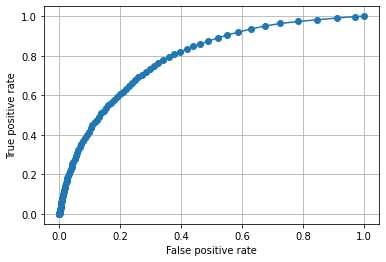

In [ ]:
# roc曲線 : thresholdsに応じた正しい値がどの程度判別出来るかを可視化したグラフ

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, marker='o')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.grid()
plt.show()

In [ ]:
# auc : y=1, x=1, y=(roc曲線)に囲まれたグラフの面積 (0 ≦ auc ≦ 1)
roc_auc_score(y_test, y_pred)

0.7884228415501106

In [ ]:
y_pred_train = rf.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred_train)

1.0

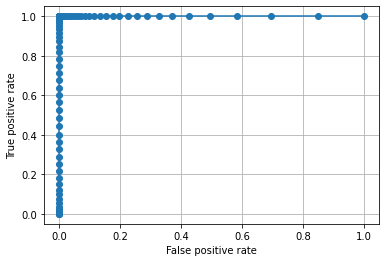

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train, y_pred_train)
plt.plot(fpr, tpr, marker='o')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.grid()
plt.show()

In [ ]:
# 上記の過学習を解消すべく、ハイパーパラメータの調整を行う。
#
# min_samples_split: ノードに属するサンプル数の最小値
# max_depth: 決定木の深さの最大値
# n_estimators: 使用する決定木数
# criterion: サンプルの分割基準(gini or entropy)
# class_weight: 不均衡データに重みをつけ調整する

params = {
    'min_samples_split': 800, # 0.8600940834562799, 0.7973188906235272
    'max_depth': None,
    'n_estimators': 60,
    'criterion': 'entoropy',
    'class_weight': 'balanced',
    'random_state': 100
}

rf2 = RandomForestClassifier(**params)
rf2.fit(X_train, y_train)
y_pred_train = rf2.predict_proba(X_train)[:, 1]
y_pred = rf2.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_train, y_pred_train))
print(roc_auc_score(y_test, y_pred))

NameError: ignored

In [ ]:
importances = pd.DataFrame({'features': X_train.columns, 'importance': rf.feature_importances_})

In [ ]:
# ascending: 昇順 or 降順
importances.sort_values('importance', ascending=False)[:20]

,features,importance
3,単勝,0.133245
4,人気,0.091566
7,体重,0.043523
8,体重変化,0.036577
1,馬番,0.036204
5,course_len,0.030789
0,枠番,0.030325
2,斤量,0.020625
6,年齢,0.019612
205,weather_晴,0.009917


# 5: 勾配ブースティング木

In [ ]:
params = {
    'num_leaves': 5, 
    'n_estimators': 80,
    'min_data_in_leaf': 5,
    'class_weight': 'balanced',
    'random_state': 100
}

lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values)
y_pred_train = lgb_clf.predict_proba(X_train)[:, 1]
y_pred = lgb_clf.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_train, y_pred_train))
print(roc_auc_score(y_test, y_pred))

# 0.8196029095895294
# 0.811714629264676

0.8196029095895294
0.811714629264676


In [ ]:
importances = pd.DataFrame({'features': X_train.columns, 'importance': lgb_clf.feature_importances_})

In [ ]:
importances.sort_values('importance', ascending=False)[:20]

,features,importance
3,単勝,138
4,人気,21
7,体重,8
6,年齢,7
179,騎手_藤田菜七,7
4402,horse_id_2016100538,5
2,斤量,4
960,horse_id_2013103646,4
1,馬番,4
3697,horse_id_2015105008,4


# 6: 複数のサイトの情報のマージ

In [ ]:
sample_date = race_results_p['date'][0]
sample_date

Timestamp('2019-07-27 00:00:00')

In [ ]:
# sample_dataの日に走った馬のhorse_idを出力
horse_id_list = race_results_p[race_results_p['date']==sample_date]['horse_id'].unique()

In [ ]:
# 上記のhorse_id(sample_dateの日に走った馬のhorse_id)にヒットする馬の情報(sample_date以外もヒットする。)
# level=0 : indexごとにグループ化する
target_df = horse_results_p.loc[horse_id_list]
target_df[target_df['date'] < sample_date].groupby(level=0)[['着順', '賞金']].mean()

,着順,賞金
2011101773,6.104167,336.072000
2011102115,5.725806,201.150000
2011103940,4.937500,345.821429
2011106405,6.739130,374.685714
2011106466,7.241379,162.615385
...,...,...
2017105318,3.000000,180.000000
2017105993,5.000000,70.000000
2017106259,4.000000,110.000000
2017106521,11.000000,NaN


In [ ]:
# horse_results_pにはあるが、horse_id_list内に無いhorse_idを出力
# invert : TrueとFalseの反転(なければTrue)
horse_id_list[np.isin(horse_id_list, horse_results_p.index, invert=True)]

array([], dtype=object)

In [ ]:
# 新しい順
sample=horse_results_p.sort_values('date', ascending=False)
sample

,着順,賞金,date
2016105434,6,NaN,2021-10-05
2016104759,2,96.0,2021-10-05
2014103284,15,NaN,2021-10-05
2015101083,10,NaN,2021-10-05
2016102769,6,NaN,2021-10-05
...,...,...,...
2007100107,2,200.0,2010-07-03
2007100107,4,75.0,2010-06-19
2007100107,7,NaN,2010-05-02
2007100107,2,200.0,2010-04-17


In [ ]:
# マージする際、賞金_ave及び着順_aveを過去n_samples回分のみに限定する。
hr = HorseResults(horse_results)
results_3R = hr.merge_all(race_results_p, n_samples=3)
results_3R.head()

100%|██████████| 110/110 [00:02<00:00, 51.24it/s]


,着順,枠番,馬番,斤量,騎手,単勝,人気,course_len,weather,race_type,ground_state,date,horse_id,jockey_id,性,年齢,体重,体重変化,着順_3R,賞金_3R
201901010101,1,1,1,54.0,ルメール,1.4,1.0,1800,曇,芝,良,2019-07-27,2017105318,05339,牡,2,518,-16,3.0,180.0
201901010101,2,3,3,54.0,岩田康誠,3.5,2.0,1800,曇,芝,良,2019-07-27,2017104612,05203,牡,2,496,-8,2.0,280.0
201901010101,3,4,4,51.0,団野大成,46.6,6.0,1800,曇,芝,良,2019-07-27,2017103879,01180,牡,2,546,6,10.0,0.0
201901010101,4,8,9,51.0,菅原明良,56.8,7.0,1800,曇,芝,良,2019-07-27,2017106259,01179,牡,2,458,-8,4.0,110.0
201901010101,5,5,5,54.0,川島信二,140.3,9.0,1800,曇,芝,良,2019-07-27,2017104140,01062,牡,2,436,0,9.0,0.0


In [ ]:
results_3R[results_3R['horse_id']=='2007100107']

,着順,枠番,馬番,斤量,騎手,単勝,人気,course_len,weather,race_type,ground_state,date,horse_id,jockey_id,性,年齢,体重,体重変化,着順_3R,賞金_3R
201907010505,7,1,1,60.0,白浜雄造,37.6,11.0,3330,晴,障害,良,2019-02-02,2007100107,01035,セ,1,552,4,8.666667,260.0
201906030108,10,8,11,60.0,平沢健治,60.7,7.0,3350,小雨,障害,稍重,2019-03-23,2007100107,01067,セ,1,536,-16,10.666667,0.0


# 7: 精度比較

In [ ]:
hr = HorseResults(horse_results)
results_5R = hr.merge_all(race_results_p, n_samples=5)
results_5R.head()

100%|██████████| 110/110 [00:02<00:00, 50.52it/s]


,着順,枠番,馬番,斤量,騎手,単勝,人気,course_len,weather,race_type,ground_state,date,horse_id,jockey_id,性,年齢,体重,体重変化,着順_5R,賞金_5R
201901010101,1,1,1,54.0,ルメール,1.4,1.0,1800,曇,芝,良,2019-07-27,2017105318,05339,牡,2,518,-16,3.0,180.0
201901010101,2,3,3,54.0,岩田康誠,3.5,2.0,1800,曇,芝,良,2019-07-27,2017104612,05203,牡,2,496,-8,2.0,280.0
201901010101,3,4,4,51.0,団野大成,46.6,6.0,1800,曇,芝,良,2019-07-27,2017103879,01180,牡,2,546,6,10.0,0.0
201901010101,4,8,9,51.0,菅原明良,56.8,7.0,1800,曇,芝,良,2019-07-27,2017106259,01179,牡,2,458,-8,4.0,110.0
201901010101,5,5,5,54.0,川島信二,140.3,9.0,1800,曇,芝,良,2019-07-27,2017104140,01062,牡,2,436,0,9.0,0.0


In [ ]:
results_5R['rank']=results_5R['着順'].map(lambda x: 1 if x<4 else 0)
results_5R.drop(['着順', '騎手', 'horse_id'], axis=1, inplace=True)

In [ ]:
results_5R.head()

,枠番,馬番,斤量,単勝,人気,course_len,weather,race_type,ground_state,date,jockey_id,性,年齢,体重,体重変化,着順_5R,賞金_5R,rank
201901010101,1,1,54.0,1.4,1.0,1800,曇,芝,良,2019-07-27,05339,牡,2,518,-16,3.0,180.0,1
201901010101,3,3,54.0,3.5,2.0,1800,曇,芝,良,2019-07-27,05203,牡,2,496,-8,2.0,280.0,1
201901010101,4,4,51.0,46.6,6.0,1800,曇,芝,良,2019-07-27,01180,牡,2,546,6,10.0,0.0,1
201901010101,8,9,51.0,56.8,7.0,1800,曇,芝,良,2019-07-27,01179,牡,2,458,-8,4.0,110.0,0
201901010101,5,5,54.0,140.3,9.0,1800,曇,芝,良,2019-07-27,01062,牡,2,436,0,9.0,0.0,0


In [ ]:
results_d=pd.get_dummies(results_5R)
results_d.head()

,枠番,馬番,斤量,単勝,人気,course_len,date,年齢,体重,体重変化,着順_5R,賞金_5R,rank,weather_小雨,weather_小雪,weather_晴,weather_曇,weather_雨,weather_雪,race_type_ダート,race_type_芝,race_type_障害,ground_state_不良,ground_state_稍重,ground_state_良,ground_state_重,horse_id_2007100107,horse_id_2008100889,horse_id_2008104268,horse_id_2009100502,horse_id_2009100509,horse_id_2009100706,horse_id_2009100957,horse_id_2009101274,horse_id_2009102606,horse_id_2009103405,horse_id_2009105407,horse_id_2010100035,horse_id_2010100155,horse_id_2010100307,...,jockey_id_05389,jockey_id_05390,jockey_id_05404,jockey_id_05411,jockey_id_05420,jockey_id_05427,jockey_id_05429,jockey_id_05469,jockey_id_05470,jockey_id_05478,jockey_id_05492,jockey_id_05495,jockey_id_05512,jockey_id_05517,jockey_id_05524,jockey_id_05525,jockey_id_05533,jockey_id_05534,jockey_id_05542,jockey_id_05543,jockey_id_05548,jockey_id_05555,jockey_id_05563,jockey_id_05568,jockey_id_05573,jockey_id_05575,jockey_id_05576,jockey_id_05577,jockey_id_05578,jockey_id_05580,jockey_id_05581,jockey_id_05584,jockey_id_05585,jockey_id_05586,jockey_id_05587,jockey_id_05588,jockey_id_05589,性_セ,性_牝,性_牡
201901010101,1,1,54.0,1.4,1.0,1800,2019-07-27,2,518,-16,3.0,180.0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
201901010101,3,3,54.0,3.5,2.0,1800,2019-07-27,2,496,-8,2.0,280.0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
201901010101,4,4,51.0,46.6,6.0,1800,2019-07-27,2,546,6,10.0,0.0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
201901010101,8,9,51.0,56.8,7.0,1800,2019-07-27,2,458,-8,4.0,110.0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
201901010101,5,5,54.0,140.3,9.0,1800,2019-07-27,2,436,0,9.0,0.0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
train_data, test_data=split_data(results_d)
train_data.head()

,枠番,馬番,斤量,単勝,人気,course_len,年齢,体重,体重変化,着順_5R,賞金_5R,rank,weather_小雨,weather_小雪,weather_晴,weather_曇,weather_雨,weather_雪,race_type_ダート,race_type_芝,race_type_障害,ground_state_不良,ground_state_稍重,ground_state_良,ground_state_重,horse_id_2007100107,horse_id_2008100889,horse_id_2008104268,horse_id_2009100502,horse_id_2009100509,horse_id_2009100706,horse_id_2009100957,horse_id_2009101274,horse_id_2009102606,horse_id_2009103405,horse_id_2009105407,horse_id_2010100035,horse_id_2010100155,horse_id_2010100307,horse_id_2010100540,...,jockey_id_05389,jockey_id_05390,jockey_id_05404,jockey_id_05411,jockey_id_05420,jockey_id_05427,jockey_id_05429,jockey_id_05469,jockey_id_05470,jockey_id_05478,jockey_id_05492,jockey_id_05495,jockey_id_05512,jockey_id_05517,jockey_id_05524,jockey_id_05525,jockey_id_05533,jockey_id_05534,jockey_id_05542,jockey_id_05543,jockey_id_05548,jockey_id_05555,jockey_id_05563,jockey_id_05568,jockey_id_05573,jockey_id_05575,jockey_id_05576,jockey_id_05577,jockey_id_05578,jockey_id_05580,jockey_id_05581,jockey_id_05584,jockey_id_05585,jockey_id_05586,jockey_id_05587,jockey_id_05588,jockey_id_05589,性_セ,性_牝,性_牡
201906010101,5,9,56.0,3.9,2.0,1200,3,500,14,3.0,180.000000,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
201906010101,7,14,52.0,76.2,11.0,1200,3,448,10,8.5,37.500000,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
201906010101,5,10,56.0,5.6,3.0,1200,3,454,6,5.2,76.000000,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
201906010101,3,6,54.0,2.4,1.0,1200,3,474,-2,3.0,151.666667,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
201906010101,4,8,56.0,11.8,5.0,1200,3,438,4,4.5,81.250000,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
X_train=train_data.drop(['rank'], axis=1)
y_train=train_data['rank']
X_test=test_data.drop(['rank'], axis=1)
y_test=test_data['rank']

In [ ]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

params = {
    'num_leaves': 5, 
    'n_estimators': 80,
    'min_data_in_leaf': 5,
    'class_weight': 'balanced',
    'random_state': 100
}

lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values)
y_pred_train = lgb_clf.predict_proba(X_train)[:, 1]
y_pred = lgb_clf.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_train, y_pred_train))
print(roc_auc_score(y_test, y_pred))

# 0.8196029095895294
# 0.811714629264676
# ↓
# 0.8201494301178001
# 0.8115088882962276
# 精度は下がったが、importancesに着順_5R及び, 賞金_5R	を用いて計算されているため、過去データの利用ができている
# →少し良くなった(ハズ)

0.8200781329913672
0.8117023695921004


In [ ]:
lgb_clf.predict_proba(X_train)

array([[0.23093175, 0.76906825],
       [0.79888615, 0.20111385],
       [0.26954647, 0.73045353],
       ...,
       [0.64852878, 0.35147122],
       [0.65897471, 0.34102529],
       [0.70493599, 0.29506401]])

In [ ]:
importances = pd.DataFrame({'features': X_train.columns, 'importance': lgb_clf.feature_importances_})

In [ ]:
importances.sort_values('importance', ascending=False)[:20]

,features,importance
3,単勝,146
4,人気,26
9,着順_5R,25
10,賞金_5R,14
6,年齢,11
7,体重,11
144,jockey_id_01164,9
1,馬番,8
2,斤量,5
8,体重変化,5


# 8: 回収率計算

In [ ]:
hr = HorseResults(horse_results)

In [ ]:
results_5R = hr.merge_all(race_results_p, n_samples=5)

100%|██████████| 110/110 [00:02<00:00, 42.67it/s]


In [ ]:
results_5R

,着順,枠番,馬番,斤量,単勝,人気,course_len,weather,race_type,ground_state,date,horse_id,jockey_id,性,年齢,体重,体重変化,着順_5R,賞金_5R
201901010101,1,1,1,54.0,1.4,1.0,1800,曇,芝,良,2019-07-27,2017105318,05339,牡,2,518,-16,3.0,180.00
201901010101,2,3,3,54.0,3.5,2.0,1800,曇,芝,良,2019-07-27,2017104612,05203,牡,2,496,-8,2.0,280.00
201901010101,3,4,4,51.0,46.6,6.0,1800,曇,芝,良,2019-07-27,2017103879,01180,牡,2,546,6,10.0,0.00
201901010101,4,8,9,51.0,56.8,7.0,1800,曇,芝,良,2019-07-27,2017106259,01179,牡,2,458,-8,4.0,110.00
201901010101,5,5,5,54.0,140.3,9.0,1800,曇,芝,良,2019-07-27,2017104140,01062,牡,2,436,0,9.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201908040412,5,5,5,57.0,15.4,7.0,1800,晴,ダート,重,2019-10-13,2014102848,01092,牡,5,492,-10,4.4,442.36
201908040412,6,2,2,57.0,36.0,9.0,1800,晴,ダート,重,2019-10-13,2012100555,01126,牡,7,526,2,6.2,239.98
201908040412,7,1,1,57.0,7.2,4.0,1800,晴,ダート,重,2019-10-13,2014105543,01122,牡,5,498,-4,4.2,477.96
201908040412,8,4,4,55.0,23.9,8.0,1800,晴,ダート,重,2019-10-13,2013103613,05429,牝,6,504,0,7.2,146.58


In [ ]:
# 着順→rank
results_5R['rank'] = results_5R['着順'].map(lambda x : 1 if x < 4 else 0)
results_5R.drop(['着順'], axis=1, inplace=True)
results_5R.head()

,枠番,馬番,斤量,単勝,人気,course_len,weather,race_type,ground_state,date,horse_id,jockey_id,性,年齢,体重,体重変化,着順_5R,賞金_5R,rank
201901010101,1,1,54.0,1.4,1.0,1800,曇,芝,良,2019-07-27,2017105318,05339,牡,2,518,-16,3.0,180.0,1
201901010101,3,3,54.0,3.5,2.0,1800,曇,芝,良,2019-07-27,2017104612,05203,牡,2,496,-8,2.0,280.0,1
201901010101,4,4,51.0,46.6,6.0,1800,曇,芝,良,2019-07-27,2017103879,01180,牡,2,546,6,10.0,0.0,1
201901010101,8,9,51.0,56.8,7.0,1800,曇,芝,良,2019-07-27,2017106259,01179,牡,2,458,-8,4.0,110.0,0
201901010101,5,5,54.0,140.3,9.0,1800,曇,芝,良,2019-07-27,2017104140,01062,牡,2,436,0,9.0,0.0,0


In [ ]:
results_5R.to_pickle('drive/My Drive/Horse_racing/pickle/results_5R.pickle')

In [ ]:
results_d = pd.get_dummies(results_5R)
train, test = split_data(results_d)
X_train = train.drop(['rank'], axis=1)
y_train = train['rank']
X_test = test.drop(['rank'], axis=1)
y_test = test['rank']

In [ ]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

params = {
    'num_leaves': 5, 
    'n_estimators': 80,
    'min_data_in_leaf': 5,
    'class_weight': 'balanced',
    'random_state': 100
}

lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values)
y_pred_train = lgb_clf.predict_proba(X_train)[:, 1]
y_pred = lgb_clf.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_train, y_pred_train))
print(roc_auc_score(y_test, y_pred))

# 0.8196029095895294
# 0.811714629264676

0.8201494301178001
0.8115088882962276


In [ ]:
me = ModelEvaluator(lgb_clf, return_tables)
me.tansho_return(X_test)

,win,return,馬番
201903030101,12.0,260.0,12
201903030101,12.0,260.0,8
201903030101,12.0,260.0,3
201903030101,12.0,260.0,14
201903030101,12.0,260.0,1
...,...,...,...
201909050912,11.0,370.0,6
201909050912,11.0,370.0,13
201909050912,11.0,370.0,16
201909050912,11.0,370.0,15


In [ ]:
gain = {}
n_samples = 100
for i in tqdm(range(n_samples)):
  threshold = i / n_samples
  gain[threshold] = me.calculate_return(X_test, threshold)

100%|██████████| 100/100 [00:08<00:00, 12.27it/s]


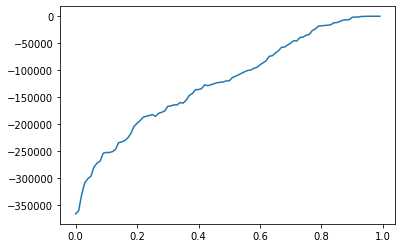

In [ ]:
pd.Series(gain).plot()

# 9: horse_idをカテゴリ変数のまま利用

In [ ]:
results_5R

,枠番,馬番,斤量,単勝,人気,course_len,weather,race_type,ground_state,date,jockey_id,性,年齢,体重,体重変化,着順_5R,賞金_5R,rank
201901010101,1,1,54.0,1.4,1.0,1800,曇,芝,良,2019-07-27,05339,牡,2,518,-16,3.0,180.00,1
201901010101,3,3,54.0,3.5,2.0,1800,曇,芝,良,2019-07-27,05203,牡,2,496,-8,2.0,280.00,1
201901010101,4,4,51.0,46.6,6.0,1800,曇,芝,良,2019-07-27,01180,牡,2,546,6,10.0,0.00,1
201901010101,8,9,51.0,56.8,7.0,1800,曇,芝,良,2019-07-27,01179,牡,2,458,-8,4.0,110.00,0
201901010101,5,5,54.0,140.3,9.0,1800,曇,芝,良,2019-07-27,01062,牡,2,436,0,9.0,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201908040412,5,5,57.0,15.4,7.0,1800,晴,ダート,重,2019-10-13,01092,牡,5,492,-10,4.4,442.36,0
201908040412,2,2,57.0,36.0,9.0,1800,晴,ダート,重,2019-10-13,01126,牡,7,526,2,6.2,239.98,0
201908040412,1,1,57.0,7.2,4.0,1800,晴,ダート,重,2019-10-13,01122,牡,5,498,-4,4.2,477.96,0
201908040412,4,4,55.0,23.9,8.0,1800,晴,ダート,重,2019-10-13,05429,牝,6,504,0,7.2,146.58,0


In [ ]:
results_5R['horse_id'].nunique()

11501

In [ ]:
results_5R['horse_id'].astype('category')

201901010101    2017105318
201901010101    2017104612
201901010101    2017103879
201901010101    2017106259
201901010101    2017104140
                   ...    
201908040412    2014102848
201908040412    2012100555
201908040412    2014105543
201908040412    2013103613
201908040412    2015101394
Name: horse_id, Length: 47118, dtype: category
Categories (11501, object): ['2007100107', '2008100889', '2008104268', '2009100502', ...,
                             '2017110171', '2017110172', '2017110173', '2017110175']

In [ ]:
from sklearn.preprocessing import LabelEncoder

LabelEncoder().fit_transform(results_5R['horse_id'])

array([10614, 10194,  9851, ...,  1985,   740,  2562])

In [ ]:
le = LabelEncoder()
le.fit(results_5R['horse_id'])
le.classes_

array(['2007100107', '2008100889', '2008104268', ..., '2017110172',
       '2017110173', '2017110175'], dtype=object)

In [ ]:
results_5R['horse_id'] = le.transform(results_5R['horse_id'])
results_5R['horse_id']

201901010101    10614
201901010101    10194
201901010101     9851
201901010101    11089
201901010101     9967
                ...  
201908040412     1535
201908040412      189
201908040412     1985
201908040412      740
201908040412     2562
Name: horse_id, Length: 47118, dtype: int64

In [ ]:
results_5R['horse_id'] = results_5R['horse_id'].astype('int')

In [ ]:
results_5R_d = pd.get_dummies(results_5R)

In [ ]:
results_5R_d.head()

,枠番,馬番,斤量,単勝,人気,course_len,date,horse_id,年齢,体重,体重変化,着順_5R,賞金_5R,rank,weather_小雨,weather_小雪,weather_晴,weather_曇,weather_雨,weather_雪,race_type_ダート,race_type_芝,race_type_障害,ground_state_不良,ground_state_稍重,ground_state_良,ground_state_重,jockey_id_00422,jockey_id_00641,jockey_id_00652,jockey_id_00660,jockey_id_00663,jockey_id_00666,jockey_id_00684,jockey_id_00689,jockey_id_00691,jockey_id_00695,jockey_id_00700,jockey_id_00722,jockey_id_00726,...,jockey_id_05389,jockey_id_05390,jockey_id_05404,jockey_id_05411,jockey_id_05420,jockey_id_05427,jockey_id_05429,jockey_id_05469,jockey_id_05470,jockey_id_05478,jockey_id_05492,jockey_id_05495,jockey_id_05512,jockey_id_05517,jockey_id_05524,jockey_id_05525,jockey_id_05533,jockey_id_05534,jockey_id_05542,jockey_id_05543,jockey_id_05548,jockey_id_05555,jockey_id_05563,jockey_id_05568,jockey_id_05573,jockey_id_05575,jockey_id_05576,jockey_id_05577,jockey_id_05578,jockey_id_05580,jockey_id_05581,jockey_id_05584,jockey_id_05585,jockey_id_05586,jockey_id_05587,jockey_id_05588,jockey_id_05589,性_セ,性_牝,性_牡
201901010101,1,1,54.0,1.4,1.0,1800,2019-07-27,10614,2,518,-16,3.0,180.0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
201901010101,3,3,54.0,3.5,2.0,1800,2019-07-27,10194,2,496,-8,2.0,280.0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
201901010101,4,4,51.0,46.6,6.0,1800,2019-07-27,9851,2,546,6,10.0,0.0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
201901010101,8,9,51.0,56.8,7.0,1800,2019-07-27,11089,2,458,-8,4.0,110.0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
201901010101,5,5,54.0,140.3,9.0,1800,2019-07-27,9967,2,436,0,9.0,0.0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
results_5R_d['horse_id'] = results_5R_d['horse_id'].astype('category')

In [ ]:
results_5R_d.head()

,枠番,馬番,斤量,単勝,人気,course_len,date,horse_id,年齢,体重,体重変化,着順_5R,賞金_5R,rank,weather_小雨,weather_小雪,weather_晴,weather_曇,weather_雨,weather_雪,race_type_ダート,race_type_芝,race_type_障害,ground_state_不良,ground_state_稍重,ground_state_良,ground_state_重,jockey_id_00422,jockey_id_00641,jockey_id_00652,jockey_id_00660,jockey_id_00663,jockey_id_00666,jockey_id_00684,jockey_id_00689,jockey_id_00691,jockey_id_00695,jockey_id_00700,jockey_id_00722,jockey_id_00726,...,jockey_id_05389,jockey_id_05390,jockey_id_05404,jockey_id_05411,jockey_id_05420,jockey_id_05427,jockey_id_05429,jockey_id_05469,jockey_id_05470,jockey_id_05478,jockey_id_05492,jockey_id_05495,jockey_id_05512,jockey_id_05517,jockey_id_05524,jockey_id_05525,jockey_id_05533,jockey_id_05534,jockey_id_05542,jockey_id_05543,jockey_id_05548,jockey_id_05555,jockey_id_05563,jockey_id_05568,jockey_id_05573,jockey_id_05575,jockey_id_05576,jockey_id_05577,jockey_id_05578,jockey_id_05580,jockey_id_05581,jockey_id_05584,jockey_id_05585,jockey_id_05586,jockey_id_05587,jockey_id_05588,jockey_id_05589,性_セ,性_牝,性_牡
201901010101,1,1,54.0,1.4,1.0,1800,2019-07-27,10614,2,518,-16,3.0,180.0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
201901010101,3,3,54.0,3.5,2.0,1800,2019-07-27,10194,2,496,-8,2.0,280.0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
201901010101,4,4,51.0,46.6,6.0,1800,2019-07-27,9851,2,546,6,10.0,0.0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
201901010101,8,9,51.0,56.8,7.0,1800,2019-07-27,11089,2,458,-8,4.0,110.0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
201901010101,5,5,54.0,140.3,9.0,1800,2019-07-27,9967,2,436,0,9.0,0.0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
results_5R_d['horse_id']

201901010101    10614
201901010101    10194
201901010101     9851
201901010101    11089
201901010101     9967
                ...  
201908040412     1535
201908040412      189
201908040412     1985
201908040412      740
201908040412     2562
Name: horse_id, Length: 47118, dtype: category
Categories (11501, int64): [0, 1, 2, 3, ..., 11497, 11498, 11499, 11500]

In [ ]:
train_data, test_data = split_data(results_5R_d)
X_train = train_data.drop(['rank'], axis='columns')
y_train = train_data['rank']
X_test = test_data.drop(['rank'], axis='columns')
y_test = test_data['rank']

In [ ]:
import lightgbm as lgb

params = {
    'num_leaves': 5, 
    'n_estimators': 80,
    'min_data_in_leaf': 5,
    'class_weight': 'balanced',
    'random_state': 100
}

lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values)
y_pred_train = lgb_clf.predict_proba(X_train)[:, 1]
y_pred = lgb_clf.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_train, y_pred_train))
print(roc_auc_score(y_test, y_pred))

# 0.8196029095895294
# 0.811714629264676

0.8205872290789176
0.8111522134573315


In [ ]:
me = ModelEvaluator(lgb_clf, return_tables)
me.feature_importance(X_test)

,features,importance
3,単勝,145
10,着順_5R,30
4,人気,26
6,horse_id,21
8,体重,13
11,賞金_5R,12
145,jockey_id_01164,8
9,体重変化,6
1,馬番,5
84,jockey_id_01087,4


In [ ]:
me.score(y_test, X_test)

0.8111522134573315

# 10: Pedsデータをマージ

In [ ]:
results_m = results_5R.merge(ped_results, left_on='horse_id', right_index=True, how='left')
results_m.head()

,枠番,馬番,斤量,単勝,人気,course_len,weather,race_type,ground_state,date,horse_id,jockey_id,性,年齢,体重,体重変化,着順_5R,賞金_5R,rank,peds_0,peds_1,peds_2,peds_3,peds_4,peds_5,peds_6,peds_7,peds_8,peds_9,peds_10,peds_11,peds_12,peds_13,peds_14,peds_15,peds_16,peds_17,peds_18,peds_19,peds_20,...,peds_22,peds_23,peds_24,peds_25,peds_26,peds_27,peds_28,peds_29,peds_30,peds_31,peds_32,peds_33,peds_34,peds_35,peds_36,peds_37,peds_38,peds_39,peds_40,peds_41,peds_42,peds_43,peds_44,peds_45,peds_46,peds_47,peds_48,peds_49,peds_50,peds_51,peds_52,peds_53,peds_54,peds_55,peds_56,peds_57,peds_58,peds_59,peds_60,peds_61
201901010101,1,1,54.0,1.4,1.0,1800,曇,芝,良,2019-07-27,2017105318,05339,牡,2,518,-16,3.0,180.0,1,ヴィクトワールピサ 2007 黒鹿毛 [血統][産駒] Halo系,ゴレラ Gorella(仏) 2002 栗毛 [血統][産駒] FNo.[9-e],ネオユニヴァース 2000 鹿毛 [血統][産駒],ホワイトウォーターアフェア Whitewater Affair(英) 1993 栗毛 [血統...,Grape Tree Road 1993 鹿毛 [血統][産駒],Exciting Times 1997 栗毛 [血統][産駒],サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒],ポインテッドパス Pointed Path(英) 1984 栗毛 [血統][産駒],Machiavellian 1987 黒鹿毛 [血統][産駒],Much Too Risky 1982 栗毛 [血統][産駒],Caerleon (米) 1980 鹿毛 [血統][産駒],One Way Street 1981 鹿毛 [血統][産駒],Jeune Homme 1990 鹿毛 [血統][産駒],Eloura 1981 鹿毛 [血統][産駒],Halo 1969 黒鹿毛,Wishing Well 1975 鹿毛,Kris 1976 栗毛,Silken Way 1973 栗毛,Mr. Prospector 1970 鹿毛,Coup de Folie 1982 鹿毛,Bustino 1971 鹿毛,...,Nijinsky 1967 鹿毛,Foreseer 1969 黒鹿毛,Habitat 1966 鹿毛,Guillotina 1969 鹿毛,Nureyev 1977 鹿毛,Alydariel 1983 栗毛,Top Ville 1976 鹿毛,Eurissia 1975 鹿毛,Hail to Reason,Cosmah,Understanding,Mountain Flower,Sharpen Up,Doubly Sure,Shantung,Boulevard,Raise a Native,Gold Digger,Halo,Raise the Standard,Busted,Ship Yard,Lorenzaccio,Short Commons,Northern Dancer,Flaming Page,Round Table,Regal Gleam,Sir Gaylord,Little Hut,Busted,Tina,Northern Dancer,Special,Alydar,Crimson Saint,High Top,Sega Ville,Sir Gaylord,Crepellana
201901010101,3,3,54.0,3.5,2.0,1800,曇,芝,良,2019-07-27,2017104612,05203,牡,2,496,-8,2.0,280.0,1,エピファネイア 2010 鹿毛 [血統][産駒] Roberto系,プントバンコ 2008 青鹿毛 [血統][産駒] FNo.[10-a],シンボリクリスエス 1999 黒鹿毛 [血統][産駒],シーザリオ 2002 青毛 [血統][産駒],フジキセキ 1992 青鹿毛 [血統][産駒],ポリーズフリート Polly's Fleet(米) 1995 栗毛 [血統][産駒],Kris S. 1977 黒鹿毛 [血統][産駒],Tee Kay 1991 黒鹿毛 [血統][産駒],スペシャルウィーク 1995 黒鹿毛 [血統][産駒],キロフプリミエール Kirov Premiere(英) 1990 鹿毛 [血統][産駒],サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒],ミルレーサー Millracer(米) 1983 鹿毛 [血統][産駒],アフリート Afleet(加) 1984 栗毛 [血統][産駒],Polly's Harde 1974 鹿毛 [血統][産駒],Roberto 1969 鹿毛,Sharp Queen 1965 鹿毛,Gold Meridian 1982 黒鹿毛,Tri Argo 1982 黒鹿毛,サンデーサイレンス 1986 青鹿毛,キャンペンガール 1987 鹿毛,Sadler's Wells 1981 鹿毛,...,Halo 1969 黒鹿毛,Wishing Well 1975 鹿毛,Le Fabuleux 1961 鹿毛,Marston's Mill 1975 黒鹿毛,Mr. Prospector 1970 鹿毛,Polite Lady 1977 鹿毛,Lyphard 1969 鹿毛,Polly's Girl 1967 鹿毛,Hail to Reason,Bramalea,Princequillo,Bridgework,Seattle Slew,Queen Louie,Tri Jet,Hail Proudly,Halo,Wishing Well,マルゼンスキー,レディーシラオキ,Northern Dancer,Fairy Bridge,Habitat,Principia,Hail to Reason,Cosmah,Understanding,Mountain Flower,Wild Risk,Anguar,In Reality,Millicent,Raise a Native,Gold Digger,Venetian Jester,Friendly Ways,Northern Dancer,Goofed,Hard Tack,Polly Macaw
201901010101,4,4,51.0,46.6,6.0,1800,曇,芝,良,2019-07-27,2017103879,01180,牡,2,546,6,10.0,0.0,1,カジノドライヴ 2005 栗毛 [血統][産駒] Seattle Slew系,フォレノワール 2010 鹿毛 [血統][産駒] FNo.[19-b],Mineshaft (米) 1999 黒鹿毛 [血統][産駒],Better Than Honour 1996 鹿毛 [血統][産駒],アグネスタキオン 1998 栗毛 [血統][産駒],ネームヴァリュー 1998 鹿毛 [血統][産駒],A.P. Indy 1989 黒鹿毛 [血統][産駒],Prospectors Delite 1989 [血統][産駒],Deputy Minister 1979 黒鹿毛 [血統][産駒],Blush With Pride 1979 栗毛 [血統][産駒],サンデーサイレンス Sunday Silence(米) 1986 青鹿毛 [血統][産駒],アグネスフローラ 1987 鹿毛 [血統][産駒],Honour and Glory 1993 鹿毛 [血統][産駒],マジソンカウンティ Madison County(米) 1991 鹿毛 [血統][産駒],Seattle Slew 1974 黒鹿毛,Weekend Surprise 1980 鹿毛,Mr. Prospector 1970 鹿毛,Up the Flagpole 1978 黒鹿毛,Vice Regent 1967 栗毛,Mint Copy 1970 黒鹿毛,Blushing Groom 1974 栗毛,...,Halo 1969 黒鹿毛,Wishing Well 1975 鹿毛,ロイヤルスキー 1974 栗毛,アグネスレディー 1976 鹿毛,Relaunch 1976 芦毛,Fair to All 1986 鹿毛,Seattle Slew 1974 黒鹿毛,Steal a Kiss 1983 鹿毛,Bold Reasoning,My Charmer,Secretariat,Lassie Dear,Raise a Native,Gold Digger,Hoist the Flag,The Gard

In [ ]:
# categorical_columns = ['horse_id'] + list(ped_results.columns)
# categorical_columns

['horse_id',
 'peds_0',
 'peds_1',
 'peds_2',
 'peds_3',
 'peds_4',
 'peds_5',
 'peds_6',
 'peds_7',
 'peds_8',
 'peds_9',
 'peds_10',
 'peds_11',
 'peds_12',
 'peds_13',
 'peds_14',
 'peds_15',
 'peds_16',
 'peds_17',
 'peds_18',
 'peds_19',
 'peds_20',
 'peds_21',
 'peds_22',
 'peds_23',
 'peds_24',
 'peds_25',
 'peds_26',
 'peds_27',
 'peds_28',
 'peds_29',
 'peds_30',
 'peds_31',
 'peds_32',
 'peds_33',
 'peds_34',
 'peds_35',
 'peds_36',
 'peds_37',
 'peds_38',
 'peds_39',
 'peds_40',
 'peds_41',
 'peds_42',
 'peds_43',
 'peds_44',
 'peds_45',
 'peds_46',
 'peds_47',
 'peds_48',
 'peds_49',
 'peds_50',
 'peds_51',
 'peds_52',
 'peds_53',
 'peds_54',
 'peds_55',
 'peds_56',
 'peds_57',
 'peds_58',
 'peds_59',
 'peds_60',
 'peds_61']

In [ ]:
from sklearn.preprocessing import LabelEncoder

for column in categorical_columns:
  results_m[column] = LabelEncoder().fit_transform(results_m[column].fillna('Na'))

In [ ]:
results_m[categorical_columns]

,horse_id,peds_0,peds_1,peds_2,peds_3,peds_4,peds_5,peds_6,peds_7,peds_8,peds_9,peds_10,peds_11,peds_12,peds_13,peds_14,peds_15,peds_16,peds_17,peds_18,peds_19,peds_20,peds_21,peds_22,peds_23,peds_24,peds_25,peds_26,peds_27,peds_28,peds_29,peds_30,peds_31,peds_32,peds_33,peds_34,peds_35,peds_36,peds_37,peds_38,peds_39,peds_40,peds_41,peds_42,peds_43,peds_44,peds_45,peds_46,peds_47,peds_48,peds_49,peds_50,peds_51,peds_52,peds_53,peds_54,peds_55,peds_56,peds_57,peds_58,peds_59,peds_60,peds_61
201901010101,10614,500,2266,179,369,178,376,98,188,93,169,27,391,316,606,15,100,56,138,65,41,33,259,79,76,133,222,208,24,838,702,8,6,82,54,67,29,111,18,57,43,62,158,22,202,122,274,48,36,149,200,159,176,51,602,118,325,18,187,166,867,815,510
201901010101,10194,220,5566,155,301,750,4613,49,139,202,319,266,755,721,1653,36,79,39,163,124,219,174,225,48,270,169,346,186,598,459,1867,8,2,59,12,66,88,131,64,27,132,176,231,91,63,85,236,21,14,192,160,197,10,155,366,135,122,455,285,266,381,366,1793
201901010101,9851,233,5189,75,23,491,3791,0,104,50,25,266,621,286,4102,38,99,70,166,114,116,26,27,48,270,409,651,236,247,706,2352,1,35,69,43,59,44,52,163,51,128,21,175,105,190,226,297,21,14,192,160,133,62,443,653,73,107,14,314,46,642,342,1878
201901010101,11089,256,1399,184,362,781,2035,21,87,36,71,266,668,987,4047,49,50,49,71,74,36,95,346,48,270,168,506,36,988,1254,3779,21,57,15,77,73,7,14,51,37,93,96,117,85,201,192,41,21,14,192,160,2,34,187,577,116,110,369,783,14,1163,1260,2930
201901010101,9967,232,7241,162,363,393,1042,98,168,46,194,189,288,80,2225,15,100,128,180,29,169,248,221,81,63,180,213,328,741,3,2475,8,6,82,54,65,28,148,182,67,28,130,191,69,149,213,231,46,86,24,232,159,321,144,234,10,39,384,409,379,11,664,2328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201908040412,1535,434,7353,152,260,829,4763,38,151,157,201,96,514,1052,4139,14,14,118,94,104,197,14,222,71,114,173,202,180,502,1202,3055,35,38,20,2,57,85,75,40,51,116,128,42,9,163,167,315,54,45,141,8,15,178,151,233,114,207,330,950,48,618,145,1888
201908040412,189,252,6591,183,277,171,1054,98,190,117,79,143,127,423,898,15,100,58,83,44,188,129,152,89,82,19,615,232,632,327,490,8,6,82,54,83,1,56,93,61,37,143,40,91,80,236,202,44,103,111,218,138,6,79,507,110,274,274,69,84,810,747,1786
201908040412,1985,256,3262,184,362,701,2079,21,87,36,71,256,480,1037,3299,49,50,49,71,74,36,95,346,56,236,145,447,199,947,1285,3030,21,57,15,77,73,7,14,51,37,93,96,117,85,201,192,41,87,63,204,139,77,346,254,84,118,103,66,656,316,824,1093,3075
201908040412,740,328,2539,152,266,530,5102,38,151,228,401,161,547,950,4434,14,14,118,94,71,221,246,375,71,181,181,578,204,433,725,1101,35,38,20,2,57,85,75,40,51,35,18,155,10,150,265,355,54,45,133,97,60,182,342,276,112,234,459,420,346,625,455,2061


In [ ]:
results_d = pd.get_dummies(results_m)

In [ ]:
for column in categorical_columns:
  results_d[column] = results_d[column].astype('category')

NameError: ignored

In [ ]:
results_d.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47118 entries, 201901010101 to 201908040412
Columns: 286 entries, 枠番 to 性_牡
dtypes: category(63), datetime64[ns](1), float64(5), int64(7), uint8(210)
memory usage: 23.4+ MB


In [ ]:
results_d = process_categorical(results_m, categorical_columns)
results_d.info()

NameError: ignored

In [ ]:
train_data, test_data = split_data(results_d)
X_train = train_data.drop(['rank'], axis='columns')
y_train = train_data['rank']
X_test = test_data.drop(['rank'], axis='columns')
y_test = test_data['rank']

In [ ]:
import lightgbm as lgb

params = {
    'num_leaves': 5, 
    'n_estimators': 80,
    'min_data_in_leaf': 5,
    'class_weight': 'balanced',
    'random_state': 100
}

lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values)
y_pred_train = lgb_clf.predict_proba(X_train)[:, 1]
y_pred = lgb_clf.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_train, y_pred_train))
print(roc_auc_score(y_test, y_pred))

0.8223062648352836
0.8112412898713679


In [ ]:
me = ModelEvaluator(lgb_clf, return_tables)

In [ ]:
me.feature_importance(X_test)

,features,importance
3,単勝,130
4,人気,21
10,着順_5R,18
6,horse_id,9
13,peds_1,8
53,peds_41,7
11,賞金_5R,7
207,jockey_id_01164,6
70,peds_58,5
63,peds_51,5


In [ ]:
from tqdm import tqdm

gain = {}
n_samples = 100
for i in tqdm(range(n_samples)):
  threshold = i / n_samples
  gain[threshold] = me.calculate_return(X_test, threshold)

100%|██████████| 100/100 [00:24<00:00,  4.16it/s]


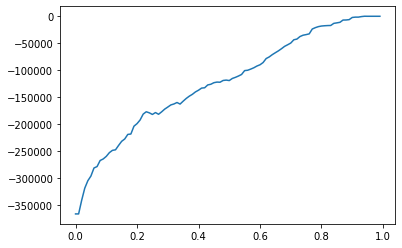

In [ ]:
pd.Series(gain).plot()

回収率 = (かけた額 + money) / かけた額

In [ ]:
me = ModelEvaluator(lgb_clf, return_tables)

In [ ]:
gain_1 = gain(me.fukusho_return, X_test)

100%|██████████| 100/100 [00:23<00:00,  4.27it/s]


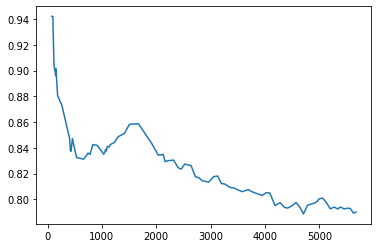

In [ ]:
gain_1.plot()

In [ ]:
gain_1

13997    0.738451
13743    0.752099
13520    0.764504
13237    0.769872
13078    0.773704
           ...   
185      0.880541
151      0.896026
98       0.941837
25       1.024000
0             NaN
Length: 94, dtype: float64

In [ ]:
gain_tansho = gain(me.tansho_return, X_test)

100%|██████████| 100/100 [00:23<00:00,  4.33it/s]


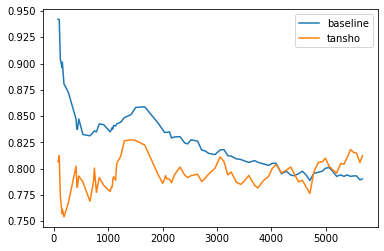

In [ ]:
gain_1.rename('baseline').plot(legend=True)
gain_tansho.rename('tansho').plot(legend=True)

In [ ]:
X_train.drop(['単勝', '人気'], axis=1, inplace=True)
X_test.drop(['単勝', '人気'], axis=1, inplace=True)

In [ ]:
import lightgbm as lgb

params = {
    'num_leaves': 5, 
    'n_estimators': 80,
    'min_data_in_leaf': 5,
    'class_weight': 'balanced',
    'random_state': 100
}

lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values)
y_pred_train = lgb_clf.predict_proba(X_train)[:, 1]
y_pred = lgb_clf.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_train, y_pred_train))
print(roc_auc_score(y_test, y_pred))

0.7401574454259061
0.709879906327999


In [ ]:
me = ModelEvaluator(lgb_clf, return_tables)

In [ ]:
gain_t2 = gain(me.tansho_return, X_test)

100%|██████████| 100/100 [00:23<00:00,  4.26it/s]


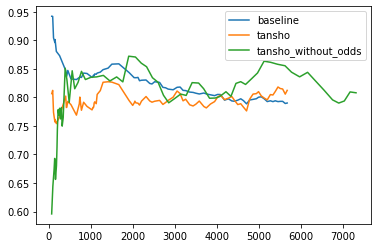

In [ ]:
gain_1.rename('baseline').plot(legend=True)
gain_tansho.rename('tansho').plot(legend=True)
gain_t2.rename('tansho_without_odds').plot(legend=True)

In [ ]:
gain_t2.max()

0.8721406086044071

In [ ]:
me.feature_importance(X_test)

,features,importance
8,着順_5R,64
4,horse_id,33
9,賞金_5R,29
6,体重,16
2,斤量,14
237,jockey_id_05339,14
145,jockey_id_01088,12
3,course_len,9
14,peds_4,8
241,jockey_id_05386,7


# 11: race_id毎に標準化する(回収率: 97%→131%)

In [ ]:
me = ModelEvaluator(lgb_clf, return_tables, std=True)

In [ ]:
gain_std = gain(me.tansho_return, X_test)

100%|██████████| 100/100 [01:30<00:00,  1.10it/s]


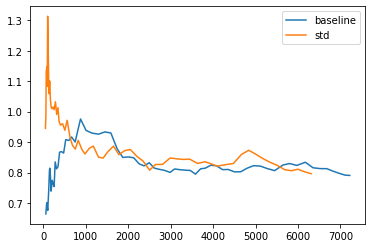

In [ ]:
baseline.rename('baseline').plot(legend=True)
gain_std.rename('std').plot(legend=True)

In [ ]:
gain_std.max()

1.3134615384615385

In [ ]:
gain_std[50:]

233    1.015451
212    1.009434
189    1.012698
170    1.035882
151    1.100662
139    1.058993
127    1.107087
120    1.171667
104    1.313462
93     1.082796
83     1.146988
78     1.137179
71     1.135211
62     0.982258
57     0.966667
51     0.945098
dtype: float64

In [ ]:
X_test.index.nunique()

1036

In [ ]:
np.sum(me.predict(X_test, threshold=0.79))

104

In [ ]:
me.pred_table(X_test, threshold=0.79)

201909040208     7
201906040201     5
201906040206    12
201909040203     8
201906040203     2
                ..
201906050802    14
201906050805     6
201906050905     9
201909050905    10
201906050910     7
Name: 馬番, Length: 104, dtype: int64

In [ ]:
_, sample = split_data(results_m)

In [ ]:
bets = sample[['着順', '人気', '単勝', '馬番']].merge(me.pred_table(X_test, threshold=0.79), left_index=True, right_index=True, how='right')

In [ ]:
bets

,着順,人気,単勝,馬番_x,馬番_y
201904030306,1,3.0,7.5,4,6
201904030306,2,1.0,1.8,6,6
201904030306,3,4.0,14.9,1,6
201904030306,4,6.0,19.7,5,6
201904030306,5,9.0,61.2,3,6
...,...,...,...,...,...
201909050905,6,6.0,31.6,3,10
201909050905,7,9.0,89.8,6,10
201909050905,8,7.0,74.2,7,10
201909050905,9,10.0,92.3,4,10


In [ ]:
# 何番人気にどの程度賭けているのか
bets[bets['馬番_x'] == bets['馬番_y']]['人気'].value_counts()

1.0     52
2.0     24
4.0      7
3.0      7
7.0      4
5.0      4
6.0      3
8.0      1
9.0      1
10.0     1
Name: 人気, dtype: int64

In [ ]:
# 単勝で当選したデータの人気と件数。
bets[(bets['馬番_x'] == bets['馬番_y'])&(bets['着順']==1)]['人気'].value_counts()

1.0    23
2.0     9
7.0     1
9.0     1
4.0     1
3.0     1
Name: 人気, dtype: int64

In [ ]:
# 単勝の当選率
sum(bets[(bets['馬番_x'] == bets['馬番_y'])&(bets['着順']==1)]['人気'].value_counts()) / sum(bets[bets['馬番_x'] == bets['馬番_y']]['人気'].value_counts()) * 100

34.61538461538461

In [ ]:
# 1位人気の馬の件数
len(sample[sample['人気']==1])

1034

In [ ]:
# 1位人気の馬のうち、当選した件数
len(sample[(sample['人気']==1)&(sample['着順']==1)])

342

# 12: データの作成
  * 下記に定義されたクラスを用いて必要なデータを抽出する。

In [203]:
rr = RaceResults(race_results)

# 前処理
rr.preprocessing()

# 馬の過去成績の追加
hr = HorseResults(horse_results)
rr.merge_horse_results(hr)

# 5世代分の血統データの追加
p = Peds(ped_results)
p.encode()
rr.merge_ped_results(p.ped_results_e)

# カテゴリ変数の処理
rr.process_categorical(rr.data_pe)

100%|██████████| 524/524 [00:58<00:00,  8.99it/s]


# 13: アルゴリズムの実用法

## 13.1: optuna

In [ ]:
# horse_results = update_data(horse_results_2019, horse_results_2020)
# ped_results = update_data(ped_results_2019, ped_results_2020)
# return_tables = update_data(return_tables_2019, return_tables_2020)

In [ ]:
# horse_results.to_pickle('drive/My Drive/Horse_racing/pickle/overall/horse_results.pickle')
# ped_results.to_pickle('drive/My Drive/Horse_racing/pickle/overall/ped_results.pickle')
# return_tables.to_pickle('drive/My Drive/Horse_racing/pickle/overall/return_tables.pickle')

In [375]:
X = rr.data_c.drop(['rank', 'date', '単勝', '体重', '体重変化'], axis=1)
y = rr.data_c['rank']

In [376]:
train, valid = split_data(rr.data_c)

X_train = train.drop(['rank', 'date', '単勝', '体重', '体重変化'], axis=1)
y_train = train['rank']
X_valid = valid.drop(['rank', 'date', '単勝', '体重', '体重変化'], axis=1)
y_valid = valid['rank']

In [377]:
pip install optuna

In [378]:
import optuna.integration.lightgbm as lgb_o

lgb_train = lgb_o.Dataset(X_train.values, y_train.values)
lgb_valid = lgb_o.Dataset(X_valid.values, y_valid.values)

# binary: 予測が0 or 1の時に使う。
params = {
    'objective': 'binary',
    'random_state': 100
}

lgb_clf_o = lgb_o.train(params,
                        lgb_train,
                        valid_sets=(lgb_train, lgb_valid),
                        verbose_eval=100,
                        early_stopping_rounds=10
                        )

[I 2021-10-29 22:24:47,722] A new study created in memory with name: no-name-8fc088f1-a5bc-4ca9-8a34-49f286a5e91e
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.430319	valid_1's binary_logloss: 0.463394


feature_fraction, val_score: 0.463206:  14%|#4        | 1/7 [00:13<01:23, 13.84s/it]

Early stopping, best iteration is:
[107]	valid_0's binary_logloss: 0.428715	valid_1's binary_logloss: 0.463206
Training until validation scores don't improve for 10 rounds.


feature_fraction, val_score: 0.463206:  29%|##8       | 2/7 [00:25<01:02, 12.54s/it]

[100]	valid_0's binary_logloss: 0.431001	valid_1's binary_logloss: 0.463959
Early stopping, best iteration is:
[90]	valid_0's binary_logloss: 0.433131	valid_1's binary_logloss: 0.463751
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.432094	valid_1's binary_logloss: 0.463071


feature_fraction, val_score: 0.463005:  43%|####2     | 3/7 [00:35<00:45, 11.29s/it]

Early stopping, best iteration is:
[98]	valid_0's binary_logloss: 0.432444	valid_1's binary_logloss: 0.463005
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.431575	valid_1's binary_logloss: 0.463148


feature_fraction, val_score: 0.463005:  57%|#####7    | 4/7 [00:45<00:32, 10.92s/it]

Early stopping, best iteration is:
[101]	valid_0's binary_logloss: 0.431305	valid_1's binary_logloss: 0.463073
Training until validation scores don't improve for 10 rounds.


feature_fraction, val_score: 0.463005:  71%|#######1  | 5/7 [00:55<00:21, 10.66s/it]

Early stopping, best iteration is:
[89]	valid_0's binary_logloss: 0.433315	valid_1's binary_logloss: 0.463088
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.429932	valid_1's binary_logloss: 0.463837


feature_fraction, val_score: 0.463005:  86%|########5 | 6/7 [01:11<00:12, 12.37s/it]

Early stopping, best iteration is:
[122]	valid_0's binary_logloss: 0.425071	valid_1's binary_logloss: 0.463711
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.429913	valid_1's binary_logloss: 0.463853


feature_fraction, val_score: 0.463005: 100%|##########| 7/7 [01:24<00:00, 12.08s/it]


Early stopping, best iteration is:
[94]	valid_0's binary_logloss: 0.431375	valid_1's binary_logloss: 0.46384


num_leaves, val_score: 0.463005:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds.


num_leaves, val_score: 0.463005:   5%|5         | 1/20 [00:13<04:11, 13.23s/it]

Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.363617	valid_1's binary_logloss: 0.466497
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.447215	valid_1's binary_logloss: 0.465507
[200]	valid_0's binary_logloss: 0.438106	valid_1's binary_logloss: 0.463829


num_leaves, val_score: 0.463005:  10%|#         | 2/20 [00:23<03:28, 11.59s/it]

Early stopping, best iteration is:
[201]	valid_0's binary_logloss: 0.438028	valid_1's binary_logloss: 0.463816
Training until validation scores don't improve for 10 rounds.


num_leaves, val_score: 0.463005:  15%|#5        | 3/20 [00:37<03:34, 12.64s/it]

Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.361761	valid_1's binary_logloss: 0.466717
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.459803	valid_1's binary_logloss: 0.472533
[200]	valid_0's binary_logloss: 0.454331	valid_1's binary_logloss: 0.469052


num_leaves, val_score: 0.463005:  20%|##        | 4/20 [00:48<03:11, 11.94s/it]

Early stopping, best iteration is:
[286]	valid_0's binary_logloss: 0.45129	valid_1's binary_logloss: 0.467634
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.410904	valid_1's binary_logloss: 0.462941


num_leaves, val_score: 0.462805:  25%|##5       | 5/20 [00:59<02:52, 11.48s/it]

Early stopping, best iteration is:
[98]	valid_0's binary_logloss: 0.411602	valid_1's binary_logloss: 0.462805
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.413702	valid_1's binary_logloss: 0.463208


num_leaves, val_score: 0.462805:  30%|###       | 6/20 [01:10<02:38, 11.32s/it]

Early stopping, best iteration is:
[98]	valid_0's binary_logloss: 0.414342	valid_1's binary_logloss: 0.463056
Training until validation scores don't improve for 10 rounds.


num_leaves, val_score: 0.462805:  35%|###5      | 7/20 [01:21<02:26, 11.26s/it]

Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.401102	valid_1's binary_logloss: 0.464556
Training until validation scores don't improve for 10 rounds.


num_leaves, val_score: 0.462805:  40%|####      | 8/20 [01:30<02:06, 10.54s/it]

Early stopping, best iteration is:
[74]	valid_0's binary_logloss: 0.427952	valid_1's binary_logloss: 0.463195
Training until validation scores don't improve for 10 rounds.


num_leaves, val_score: 0.462805:  45%|####5     | 9/20 [01:40<01:56, 10.57s/it]

Early stopping, best iteration is:
[74]	valid_0's binary_logloss: 0.408816	valid_1's binary_logloss: 0.464018
Training until validation scores don't improve for 10 rounds.


num_leaves, val_score: 0.462805:  50%|#####     | 10/20 [01:52<01:48, 10.84s/it]

Early stopping, best iteration is:
[73]	valid_0's binary_logloss: 0.396143	valid_1's binary_logloss: 0.464351
Training until validation scores don't improve for 10 rounds.


num_leaves, val_score: 0.462805:  55%|#####5    | 11/20 [02:05<01:43, 11.45s/it]

Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.375019	valid_1's binary_logloss: 0.465503
Training until validation scores don't improve for 10 rounds.


num_leaves, val_score: 0.462805:  60%|######    | 12/20 [02:15<01:28, 11.02s/it]

Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.41002	valid_1's binary_logloss: 0.46331
Training until validation scores don't improve for 10 rounds.


num_leaves, val_score: 0.462805:  65%|######5   | 13/20 [02:24<01:13, 10.45s/it]

Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.426172	valid_1's binary_logloss: 0.463615
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.426295	valid_1's binary_logloss: 0.463312


num_leaves, val_score: 0.462805:  70%|#######   | 14/20 [02:34<01:02, 10.41s/it]

Early stopping, best iteration is:
[122]	valid_0's binary_logloss: 0.420779	valid_1's binary_logloss: 0.463044
Training until validation scores don't improve for 10 rounds.


num_leaves, val_score: 0.462805:  75%|#######5  | 15/20 [02:47<00:55, 11.07s/it]

Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.377381	valid_1's binary_logloss: 0.465101
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.43424	valid_1's binary_logloss: 0.463519


num_leaves, val_score: 0.462805:  80%|########  | 16/20 [02:57<00:42, 10.70s/it]

Early stopping, best iteration is:
[127]	valid_0's binary_logloss: 0.428871	valid_1's binary_logloss: 0.462843
Training until validation scores don't improve for 10 rounds.


num_leaves, val_score: 0.462805:  85%|########5 | 17/20 [03:08<00:32, 10.82s/it]

Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.403367	valid_1's binary_logloss: 0.463823
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.435008	valid_1's binary_logloss: 0.463489


num_leaves, val_score: 0.462805:  90%|######### | 18/20 [03:17<00:20, 10.27s/it]

Early stopping, best iteration is:
[107]	valid_0's binary_logloss: 0.433633	valid_1's binary_logloss: 0.463342
Training until validation scores don't improve for 10 rounds.


num_leaves, val_score: 0.462805:  95%|#########5| 19/20 [03:28<00:10, 10.64s/it]

Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.387469	valid_1's binary_logloss: 0.465335
Training until validation scores don't improve for 10 rounds.


num_leaves, val_score: 0.462805: 100%|##########| 20/20 [03:38<00:00, 10.93s/it]


Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.412767	valid_1's binary_logloss: 0.46346


bagging, val_score: 0.462805:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds.


bagging, val_score: 0.462805:  10%|#         | 1/10 [00:09<01:23,  9.32s/it]

Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.423649	valid_1's binary_logloss: 0.464024
Training until validation scores don't improve for 10 rounds.


bagging, val_score: 0.462805:  20%|##        | 2/10 [00:18<01:14,  9.27s/it]

Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.417736	valid_1's binary_logloss: 0.46565
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.410456	valid_1's binary_logloss: 0.463764


bagging, val_score: 0.462805:  30%|###       | 3/10 [00:29<01:11, 10.19s/it]

Early stopping, best iteration is:
[94]	valid_0's binary_logloss: 0.41279	valid_1's binary_logloss: 0.463616
Training until validation scores don't improve for 10 rounds.


bagging, val_score: 0.462805:  40%|####      | 4/10 [00:39<00:59,  9.90s/it]

Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.418601	valid_1's binary_logloss: 0.464414
Training until validation scores don't improve for 10 rounds.


bagging, val_score: 0.462805:  50%|#####     | 5/10 [00:49<00:49,  9.96s/it]

Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.419353	valid_1's binary_logloss: 0.463887
Training until validation scores don't improve for 10 rounds.


bagging, val_score: 0.462805:  60%|######    | 6/10 [00:58<00:38,  9.54s/it]

Early stopping, best iteration is:
[77]	valid_0's binary_logloss: 0.420711	valid_1's binary_logloss: 0.464773
Training until validation scores don't improve for 10 rounds.


bagging, val_score: 0.462805:  70%|#######   | 7/10 [01:07<00:28,  9.59s/it]

Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.420164	valid_1's binary_logloss: 0.464329
Training until validation scores don't improve for 10 rounds.


bagging, val_score: 0.462805:  80%|########  | 8/10 [01:16<00:18,  9.40s/it]

Early stopping, best iteration is:
[82]	valid_0's binary_logloss: 0.418951	valid_1's binary_logloss: 0.465623
Training until validation scores don't improve for 10 rounds.


bagging, val_score: 0.462805:  90%|######### | 9/10 [01:26<00:09,  9.35s/it]

Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.423024	valid_1's binary_logloss: 0.46363
Training until validation scores don't improve for 10 rounds.


bagging, val_score: 0.462805: 100%|##########| 10/10 [01:35<00:00,  9.51s/it]


Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.418982	valid_1's binary_logloss: 0.4656


feature_fraction_stage2, val_score: 0.462805:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds.


feature_fraction_stage2, val_score: 0.462805:  33%|###3      | 1/3 [00:10<00:20, 10.22s/it]

[100]	valid_0's binary_logloss: 0.41048	valid_1's binary_logloss: 0.463142
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.413928	valid_1's binary_logloss: 0.463056
Training until validation scores don't improve for 10 rounds.


feature_fraction_stage2, val_score: 0.462805:  67%|######6   | 2/3 [00:20<00:10, 10.00s/it]

Early stopping, best iteration is:
[77]	valid_0's binary_logloss: 0.419073	valid_1's binary_logloss: 0.463285
Training until validation scores don't improve for 10 rounds.


feature_fraction_stage2, val_score: 0.462805: 100%|##########| 3/3 [00:29<00:00,  9.90s/it]


Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.42352	valid_1's binary_logloss: 0.463949


regularization_factors, val_score: 0.462805:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.411782	valid_1's binary_logloss: 0.462673


regularization_factors, val_score: 0.462641:   5%|5         | 1/20 [00:11<03:33, 11.23s/it]

Early stopping, best iteration is:
[105]	valid_0's binary_logloss: 0.409958	valid_1's binary_logloss: 0.462641
Training until validation scores don't improve for 10 rounds.


regularization_factors, val_score: 0.462579:  10%|#         | 2/20 [00:22<03:18, 11.00s/it]

Early stopping, best iteration is:
[87]	valid_0's binary_logloss: 0.42	valid_1's binary_logloss: 0.462579
Training until validation scores don't improve for 10 rounds.


regularization_factors, val_score: 0.462579:  15%|#5        | 3/20 [00:31<02:52, 10.16s/it]

Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.423188	valid_1's binary_logloss: 0.463364
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.410904	valid_1's binary_logloss: 0.462942


regularization_factors, val_score: 0.462579:  20%|##        | 4/20 [00:41<02:44, 10.28s/it]

Early stopping, best iteration is:
[98]	valid_0's binary_logloss: 0.411602	valid_1's binary_logloss: 0.462807
Training until validation scores don't improve for 10 rounds.


regularization_factors, val_score: 0.462579:  25%|##5       | 5/20 [00:51<02:29,  9.95s/it]

Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.423618	valid_1's binary_logloss: 0.463305
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.410904	valid_1's binary_logloss: 0.46294


regularization_factors, val_score: 0.462579:  30%|###       | 6/20 [01:01<02:23, 10.22s/it]

Early stopping, best iteration is:
[98]	valid_0's binary_logloss: 0.411602	valid_1's binary_logloss: 0.462805
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.410904	valid_1's binary_logloss: 0.462941


regularization_factors, val_score: 0.462579:  35%|###5      | 7/20 [01:12<02:15, 10.40s/it]

Early stopping, best iteration is:
[98]	valid_0's binary_logloss: 0.411602	valid_1's binary_logloss: 0.462804
Training until validation scores don't improve for 10 rounds.


regularization_factors, val_score: 0.462486:  40%|####      | 8/20 [01:23<02:07, 10.63s/it]

Early stopping, best iteration is:
[89]	valid_0's binary_logloss: 0.419568	valid_1's binary_logloss: 0.462486
Training until validation scores don't improve for 10 rounds.


regularization_factors, val_score: 0.462486:  45%|####5     | 9/20 [01:34<01:58, 10.74s/it]

[100]	valid_0's binary_logloss: 0.414777	valid_1's binary_logloss: 0.462986
Early stopping, best iteration is:
[92]	valid_0's binary_logloss: 0.41748	valid_1's binary_logloss: 0.462896
Training until validation scores don't improve for 10 rounds.


regularization_factors, val_score: 0.462486:  50%|#####     | 10/20 [01:43<01:42, 10.24s/it]

Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.423523	valid_1's binary_logloss: 0.463131
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.410952	valid_1's binary_logloss: 0.462833


regularization_factors, val_score: 0.462486:  55%|#####5    | 11/20 [01:54<01:34, 10.50s/it]

Early stopping, best iteration is:
[107]	valid_0's binary_logloss: 0.408328	valid_1's binary_logloss: 0.462674
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.418884	valid_1's binary_logloss: 0.461961


regularization_factors, val_score: 0.461542:  60%|######    | 12/20 [02:07<01:30, 11.26s/it]

Early stopping, best iteration is:
[119]	valid_0's binary_logloss: 0.4134	valid_1's binary_logloss: 0.461542
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.418403	valid_1's binary_logloss: 0.461969


regularization_factors, val_score: 0.461542:  65%|######5   | 13/20 [02:21<01:22, 11.83s/it]

Early stopping, best iteration is:
[119]	valid_0's binary_logloss: 0.413003	valid_1's binary_logloss: 0.461741
Training until validation scores don't improve for 10 rounds.


regularization_factors, val_score: 0.461542:  70%|#######   | 14/20 [02:30<01:06, 11.09s/it]

Early stopping, best iteration is:
[72]	valid_0's binary_logloss: 0.422031	valid_1's binary_logloss: 0.463357
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.419538	valid_1's binary_logloss: 0.462105


regularization_factors, val_score: 0.461542:  75%|#######5  | 15/20 [02:43<00:58, 11.71s/it]

Early stopping, best iteration is:
[124]	valid_0's binary_logloss: 0.412765	valid_1's binary_logloss: 0.461881
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.410905	valid_1's binary_logloss: 0.462941


regularization_factors, val_score: 0.461542:  80%|########  | 16/20 [02:54<00:46, 11.54s/it]

Early stopping, best iteration is:
[98]	valid_0's binary_logloss: 0.411603	valid_1's binary_logloss: 0.462805
Training until validation scores don't improve for 10 rounds.


regularization_factors, val_score: 0.461542:  85%|########5 | 17/20 [03:05<00:33, 11.33s/it]

Early stopping, best iteration is:
[87]	valid_0's binary_logloss: 0.420532	valid_1's binary_logloss: 0.462294
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.411199	valid_1's binary_logloss: 0.462729


regularization_factors, val_score: 0.461542:  90%|######### | 18/20 [03:16<00:22, 11.33s/it]

Early stopping, best iteration is:
[109]	valid_0's binary_logloss: 0.407652	valid_1's binary_logloss: 0.462618
Training until validation scores don't improve for 10 rounds.


regularization_factors, val_score: 0.461542:  95%|#########5| 19/20 [03:25<00:10, 10.63s/it]

Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.424995	valid_1's binary_logloss: 0.463293
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.410904	valid_1's binary_logloss: 0.462946


regularization_factors, val_score: 0.461542: 100%|##########| 20/20 [03:36<00:00, 10.83s/it]


Early stopping, best iteration is:
[98]	valid_0's binary_logloss: 0.411602	valid_1's binary_logloss: 0.462809


min_data_in_leaf, val_score: 0.461542:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.418773	valid_1's binary_logloss: 0.461812


min_data_in_leaf, val_score: 0.461415:  20%|##        | 1/5 [00:12<00:51, 12.79s/it]

Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.412988	valid_1's binary_logloss: 0.461415
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.41881	valid_1's binary_logloss: 0.461792


min_data_in_leaf, val_score: 0.461415:  40%|####      | 2/5 [00:24<00:36, 12.05s/it]

Early stopping, best iteration is:
[95]	valid_0's binary_logloss: 0.42033	valid_1's binary_logloss: 0.461772
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.418779	valid_1's binary_logloss: 0.461871


min_data_in_leaf, val_score: 0.461415:  60%|######    | 3/5 [00:38<00:26, 13.00s/it]

Early stopping, best iteration is:
[127]	valid_0's binary_logloss: 0.411063	valid_1's binary_logloss: 0.461647
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.418848	valid_1's binary_logloss: 0.462171


min_data_in_leaf, val_score: 0.461415:  80%|########  | 4/5 [00:50<00:12, 12.75s/it]

Early stopping, best iteration is:
[101]	valid_0's binary_logloss: 0.418573	valid_1's binary_logloss: 0.46215
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.418748	valid_1's binary_logloss: 0.462074


min_data_in_leaf, val_score: 0.461415: 100%|##########| 5/5 [01:05<00:00, 13.04s/it]

Early stopping, best iteration is:
[137]	valid_0's binary_logloss: 0.408219	valid_1's binary_logloss: 0.46163


In [382]:
lgb_clf_o.params

# {'bagging_fraction': 1.0,
#  'bagging_freq': 0,
#  'feature_fraction': 0.4,
#  'feature_pre_filter': False,
#  'lambda_l1': 3.7668588413648623,
#  'lambda_l2': 7.685013396448601,
#  'min_child_samples': 25,
#  'num_leaves': 31,
#  'objective': 'binary',
#  'random_state': 100}

# {'bagging_fraction': 1.0,
#  'bagging_freq': 0,
#  'feature_fraction': 0.41600000000000004,
#  'feature_pre_filter': False,
#  'lambda_l1': 7.144045559625428,
#  'lambda_l2': 0.14522987833541556,
#  'min_child_samples': 20,
#  'num_leaves': 37,
#  'objective': 'binary',
#  'random_state': 100}

{'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'feature_fraction': 0.4,
 'feature_pre_filter': False,
 'lambda_l1': 8.122510065481238,
 'lambda_l2': 2.9635557987860523e-06,
 'min_child_samples': 50,
 'num_leaves': 63,
 'objective': 'binary',
 'random_state': 100}

In [381]:
lgb_clf = lgb.LGBMClassifier(**lgb_clf_o.params)
lgb_clf.fit(X.values, y.values)

LGBMClassifier(bagging_fraction=1.0, bagging_freq=0, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.4,
               feature_pre_filter=False, importance_type='split',
               lambda_l1=8.122510065481238, lambda_l2=2.9635557987860523e-06,
               learning_rate=0.1, max_depth=-1, min_child_samples=50,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=63, objective='binary', random_state=100,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

## 13.2 出馬表

In [337]:
# 出馬表データのスクレイピング
# 欲しい出馬表のrace_id, 日付を引数とする。
# 2021050405: 2021 10/23 東京
# url = "https://db.netkeiba.com/race/" + race_id

race_id_list = ['2021050406{}'.format(str(i).zfill(2)) for i in range(1, 13)]

In [412]:
st = ShutubaTable.scrape(race_id_list=race_id_list, date='2021/10/30')

100%|██████████| 12/12 [00:24<00:00,  2.05s/it]


In [413]:
# 出馬表データを作成する。

st.preprocessing()

st.merge_horse_results(hr)

st.merge_ped_results(p.ped_results_e)

st.process_categorical(results_m = rr.data_pe)

st.data_c.head()

100%|██████████| 1/1 [00:00<00:00,  9.42it/s]


please scrape ped_results at horse_id_list "no_peds"


,枠番,馬番,斤量,course_len,date,horse_id,jockey_id,年齢,体重,体重変化,n_horses,着順_5R,賞金_5R,着差_5R,first_corner_5R,final_corner_5R,first_to_rank_5R,first_to_final_5R,final_to_rank_5R,着順_course_len_5R,賞金_course_len_5R,着差_course_len_5R,first_corner_course_len_5R,final_corner_course_len_5R,first_to_rank_course_len_5R,first_to_final_course_len_5R,final_to_rank_course_len_5R,着順_race_type_5R,賞金_race_type_5R,着差_race_type_5R,first_corner_race_type_5R,final_corner_race_type_5R,first_to_rank_race_type_5R,first_to_final_race_type_5R,final_to_rank_race_type_5R,着順_開催_5R,賞金_開催_5R,着差_開催_5R,first_corner_開催_5R,final_corner_開催_5R,...,peds_38,peds_39,peds_40,peds_41,peds_42,peds_43,peds_44,peds_45,peds_46,peds_47,peds_48,peds_49,peds_50,peds_51,peds_52,peds_53,peds_54,peds_55,peds_56,peds_57,peds_58,peds_59,peds_60,peds_61,weather_晴,weather_曇,weather_雨,weather_小雨,weather_小雪,weather_雪,race_type_芝,race_type_ダート,race_type_障害,ground_state_良,ground_state_稍重,ground_state_重,ground_state_不良,性_牝,性_牡,性_セ
202105040601,1,1,54,1600,2021-10-30,90,21,2,0,0,11,13.00,0.0,4.10,13.666667,14.0,0.666667,-0.333333,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.00,0.0,4.70,13.00,13.0,0.0,0.00,0.00,13.0,0.0,4.70,13.0,13.0,...,62,38,75,41,0,141,163,415,28,28,239,200,181,93,524,909,114,294,437,1105,431,303,140,1512,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0
202105040601,2,2,55,1600,2021-10-30,81,5,2,0,0,11,9.50,0.0,1.70,12.500000,11.0,3.000000,1.500000,1.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.00,0.0,1.30,9.00,9.0,3.0,0.00,3.00,9.5,0.0,1.70,12.5,11.0,...,30,26,204,176,115,175,388,550,64,163,263,361,144,211,14,553,81,84,554,666,326,1201,1009,1693,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0
202105040601,3,3,55,1600,2021-10-30,104,3,2,0,0,11,9.25,0.0,2.70,9.750000,9.5,0.500000,0.250000,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.25,0.0,2.70,9.75,9.5,0.5,0.25,0.25,10.0,0.0,4.15,10.0,10.0,...,88,162,74,270,151,62,112,8,28,28,93,191,141,122,420,161,164,155,415,53,116,1163,1176,2947,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0
202105040601,4,4,55,1600,2021-10-30,108,0,2,0,0,11,1.50,395.0,0.05,2.000000,2.0,0.500000,0.000000,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.50,395.0,0.05,2.00,2.0,0.5,0.00,0.50,1.0,510.0,0.00,2.0,2.0,...,88,8,150,25,118,322,119,488,28,28,239,200,5,45,232,740,127,259,454,392,15,631,421,2035,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0
202105040601,5,5,55,1600,2021-10-30,139,6,2,0,0,11,7.50,0.0,2.55,8.500000,8.0,1.000000,0.500000,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.50,0.0,2.55,8.50,8.0,1.0,0.50,0.50,7.5,0.0,2.55,8.5,8.0,...,71,52,24,40,115,198,270,97,57,116,244,160,174,236,80,908,202,392,452,171,343,692,1388,3600,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0


## 13.3 複勝馬の予想

In [419]:
# ModelEvaluator
me = ModelEvaluator(lgb_clf, ['drive/My Drive/Horse_racing/pickle/overall/return_tables.pickle'])

In [420]:
X_fact = st.data_c.drop(['date', '体重', '体重変化'], axis=1)

In [421]:
# MLが予想する信憑性が高い馬n選
# pred = me.predict_proba(st.data_c.drop(['date'], axis=1), train=False)
pred = me.predict_proba(X_fact, train=False)
proba_table = st.data_c[['馬番']].copy()
proba_table['score'] = pred
proba_table.sort_values('score', ascending = False).head(10)
# 202105040605	2	3.394098
# 202105040608	11	2.801649
# 202105040604	1	2.341503
# 202105040604	16	1.959311
# 202105040610	10	1.864300
# 202105040602	1	1.798313
# 202105040611	6	1.745137
# 202105040603	7	1.683575
# 202105040609	5	1.646177
# 202105040602	11	1.606155

,馬番,score
202105040608,11,2.641715
202105040602,1,2.451781
202105040611,6,2.339163
202105040610,10,2.073313
202105040603,7,1.901831
202105040604,16,1.684182
202105040612,2,1.671790
202105040601,4,1.650265
202105040609,5,1.632813
202105040604,7,1.531696


In [430]:
# あるscore以上の馬番のみを出力する。
# 三連複, 三連単: 1.5前後
# 馬連, 馬単: 2.3前後
# 単勝: 3.4前後
pred_table = me.pred_table(X_fact, threshold=1.3, tansho=False, train=False)
for race_id, preds in pred_table.groupby(level=0):
  if len(preds) >= 3: # 馬単, 馬連や三連単, 三連複には不必要なデータを取り除くことが可能
    display(preds)

,馬番,score
202105040601,4,1.650265
202105040601,7,1.334145
202105040601,11,1.336327


,馬番,score
202105040602,1,2.451781
202105040602,11,1.467067


,馬番,score
202105040604,7,1.531696
202105040604,10,1.336920
202105040604,16,1.684182


,馬番,score
202105040608,1,1.419515
202105040608,11,2.641715


In [432]:
me.feature_importance(X_fact)

,features,importance
5,jockey_id,396
25,賞金_race_type_5R,147
104,interval,122
3,course_len,112
73,賞金_allR,111
6,年齢,109
7,n_horses,107
89,賞金_race_type_allR,104
4,horse_id,99
9,賞金_5R,95


## 13.4 払い戻し表
※ 既に終了しているレースのみ有効

In [75]:
# (既に終了しているレースに限る) 払い戻し表の出力
rt = Return(return_tables_today)

In [74]:
return_tables_today = Return.scrape(race_id_list)

100%|██████████| 12/12 [00:19<00:00,  1.62s/it]


## 13.5 当選結果
※ 既に終了しているレースのみ有効

In [217]:
# レースデータを抽出

race_results2 = RaceResults.scrape(race_id_list)
rr2 = RaceResults(race_results2)

# 前処理
rr2.preprocessing()

# 馬の過去成績の追加
horse_id_list2 = race_results2['horse_id'].unique()
hr2 = HorseResults(HorseResults.scrape(horse_id_list2))
rr2.merge_horse_results(hr)

# 5世代分の血統データの追加
p2 = Peds(Peds.scrape(horse_id_list2))
p2.encode()
rr2.merge_ped_results(p.ped_results_e)

# カテゴリ変数の処理
rr2.process_categorical(rr.data_pe)

 53%|█████▎    | 94/177 [02:18<01:54,  1.38s/it]/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

100%|██████████| 177/177 [04:20<00:00,  1.47s/it]

please scrape ped_results at horse_id_list "no_peds"


In [346]:
rr2.data_c['単勝']

202105040501      6.4
202105040501      5.5
202105040501     71.8
202105040501     19.8
202105040501     15.9
                ...  
202105040512     69.9
202105040512    274.8
202105040512     26.2
202105040512    117.8
202105040512     25.6
Name: 単勝, Length: 177, dtype: float64

In [359]:
# 計算の都合に合わせたデータの加工
X_fact = rr2.data_c.drop(['rank', 'date'], axis=1)

In [239]:
# 三連複の結果の計算
temp = gain(me.sanrenpuku_box, X_fact)

 30%|███       | 30/100 [00:04<00:10,  6.93it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:237: RuntimeWarning:

invalid value encountered in double_scalars

 31%|███       | 31/100 [00:04<00:09,  7.07it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:234: RuntimeWarning:

Degrees of freedom <= 0 for slice

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:195: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning:

invalid value encountered in double_scalars

/usr/local/lib/python3.7/dis

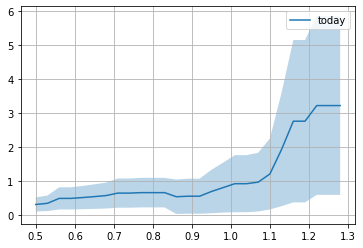

In [242]:
# thresholdごとの回収率
plot(temp, 'today')

In [272]:
# n_bets, return_rate, n_hits, std
me.sanrenpuku_box(X_fact, threshold=1.2, show=True)

,馬番,単勝,score
202105040501,1,5.5,1.837845
202105040501,3,3.4,2.314353
202105040501,6,18.9,1.209803
202105040508,8,1.7,1.597107
202105040508,15,15.7,1.306824
202105040508,14,7.0,1.507425
202105040508,11,6.8,1.397927
202105040510,3,11.0,1.411355
202105040510,10,8.4,1.351246
202105040510,1,3.7,1.780116


(7, 2.757142857142857, 1, 2.387755756148524)

# 14: 単勝適正回収値
常に払戻額が一定になるように単勝でかけた場合の回収率

払戻額が1万円になるようにかける

In [ ]:
me = ModelEvaluator(lgb_clf, return_tables)
me.tansho_return_proper(X_test)

(12771, 0.479537115817437)

In [ ]:
baseline = gain(me.tansho_return, X_test)

100%|██████████| 100/100 [02:54<00:00,  1.74s/it]


In [ ]:
gain_proper = gain(me.tansho_return_proper, X_test)

100%|██████████| 100/100 [02:55<00:00,  1.75s/it]


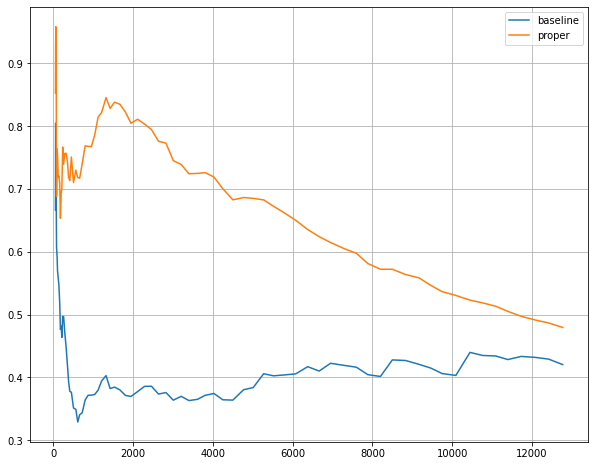

In [ ]:
plt.figure(figsize=(10, 8))
baseline.rename('baseline').plot(legend=True)
gain_proper.rename('proper').plot(legend=True)
plt.grid()

# 15: Optuna

1. あるハイパーパラメータを用いて、lgb_trainで学習
2. そのモデルを用いてlgb_validで検証
3. 検証結果を利用して、ハイパーパラメータを変えてlgb_trainで再学習
4. 2-3を繰り返す。



In [ ]:
pip install optuna

     |████████████████████████████████| 308 kB 5.4 MB/s 
     |████████████████████████████████| 209 kB 43.6 MB/s 
     |████████████████████████████████| 80 kB 7.9 MB/s 
     |████████████████████████████████| 75 kB 3.9 MB/s 
     |████████████████████████████████| 49 kB 5.9 MB/s 
     |████████████████████████████████| 111 kB 61.1 MB/s 
     |████████████████████████████████| 144 kB 59.7 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=7d8f4f3645e5fc29735c091e19b92dc498834aca8f3bf8107fd5263507000309
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
# 訓練データ、検証データ、テストデータに分ける
train, test = split_data(rr.data_c)
train, valid = split_data(train)

In [ ]:
X_train = train.drop(['rank', 'date', '単勝'], axis=1)
y_train = train['rank']
X_valid = valid.drop(['rank', 'date', '単勝'], axis=1)
y_valid = valid['rank']

In [ ]:
import optuna.integration.lightgbm as lgb_o

lgb_train = lgb_o.Dataset(X_train.values, y_train.values)
lgb_valid = lgb_o.Dataset(X_valid.values, y_valid.values)

# binary: 予測が0 or 1の時に使う。
params = {
    'objective': 'binary',
    'random_state': 100
}

lgb_clf_o = lgb_o.train(params,
                        lgb_train,
                        valid_sets=(lgb_train, lgb_valid),
                        verbose_eval=100,
                        early_stopping_rounds=10
                        )

[I 2021-10-27 05:24:08,382] A new study created in memory with name: no-name-ca39da90-2411-4f11-ac2f-7ee9da2f9f90
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.420175	valid_1's binary_logloss: 0.460981


feature_fraction, val_score: 0.460892:  14%|#4        | 1/7 [00:09<00:58,  9.73s/it]

Early stopping, best iteration is:
[111]	valid_0's binary_logloss: 0.417061	valid_1's binary_logloss: 0.460892
Training until validation scores don't improve for 10 rounds.


feature_fraction, val_score: 0.460892:  29%|##8       | 2/7 [00:17<00:42,  8.52s/it]

Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.424062	valid_1's binary_logloss: 0.460913
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.41877	valid_1's binary_logloss: 0.460811


feature_fraction, val_score: 0.460629:  43%|####2     | 3/7 [00:30<00:42, 10.54s/it]

Early stopping, best iteration is:
[128]	valid_0's binary_logloss: 0.411067	valid_1's binary_logloss: 0.460629
Training until validation scores don't improve for 10 rounds.


feature_fraction, val_score: 0.460629:  57%|#####7    | 4/7 [00:41<00:32, 10.74s/it]

Early stopping, best iteration is:
[88]	valid_0's binary_logloss: 0.422004	valid_1's binary_logloss: 0.461059
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.417992	valid_1's binary_logloss: 0.461675


feature_fraction, val_score: 0.460629:  71%|#######1  | 5/7 [00:53<00:22, 11.40s/it]

Early stopping, best iteration is:
[94]	valid_0's binary_logloss: 0.419744	valid_1's binary_logloss: 0.46153
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.419065	valid_1's binary_logloss: 0.460377


feature_fraction, val_score: 0.460352:  86%|########5 | 6/7 [01:04<00:11, 11.12s/it]

Early stopping, best iteration is:
[101]	valid_0's binary_logloss: 0.418794	valid_1's binary_logloss: 0.460352
Training until validation scores don't improve for 10 rounds.


feature_fraction, val_score: 0.460352: 100%|##########| 7/7 [01:13<00:00, 10.47s/it]


Early stopping, best iteration is:
[83]	valid_0's binary_logloss: 0.424258	valid_1's binary_logloss: 0.460928


num_leaves, val_score: 0.460352:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds.


num_leaves, val_score: 0.460352:   5%|5         | 1/20 [00:16<05:07, 16.19s/it]

Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.349455	valid_1's binary_logloss: 0.464296
Training until validation scores don't improve for 10 rounds.


num_leaves, val_score: 0.460352:  10%|#         | 2/20 [00:32<04:51, 16.21s/it]

Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.346725	valid_1's binary_logloss: 0.464757
Training until validation scores don't improve for 10 rounds.


num_leaves, val_score: 0.460352:  15%|#5        | 3/20 [00:43<03:56, 13.93s/it]

Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.400281	valid_1's binary_logloss: 0.462646
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.421606	valid_1's binary_logloss: 0.46113


num_leaves, val_score: 0.460352:  20%|##        | 4/20 [00:54<03:22, 12.66s/it]

Early stopping, best iteration is:
[111]	valid_0's binary_logloss: 0.418758	valid_1's binary_logloss: 0.460933
Training until validation scores don't improve for 10 rounds.


num_leaves, val_score: 0.460352:  25%|##5       | 5/20 [01:07<03:14, 12.98s/it]

Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.367792	valid_1's binary_logloss: 0.463692
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.409094	valid_1's binary_logloss: 0.461185


num_leaves, val_score: 0.460352:  30%|###       | 6/20 [01:19<02:53, 12.36s/it]

Early stopping, best iteration is:
[96]	valid_0's binary_logloss: 0.410709	valid_1's binary_logloss: 0.461083
Training until validation scores don't improve for 10 rounds.


num_leaves, val_score: 0.460352:  35%|###5      | 7/20 [01:35<02:57, 13.67s/it]

Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.350388	valid_1's binary_logloss: 0.464349
Training until validation scores don't improve for 10 rounds.


num_leaves, val_score: 0.460352:  40%|####      | 8/20 [01:48<02:40, 13.34s/it]

Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.372564	valid_1's binary_logloss: 0.462882
Training until validation scores don't improve for 10 rounds.


num_leaves, val_score: 0.460352:  45%|####5     | 9/20 [02:02<02:30, 13.68s/it]

Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.348219	valid_1's binary_logloss: 0.463989
Training until validation scores don't improve for 10 rounds.


num_leaves, val_score: 0.460352:  50%|#####     | 10/20 [02:17<02:19, 13.96s/it]

Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.350585	valid_1's binary_logloss: 0.464223
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.451907	valid_1's binary_logloss: 0.467953
[200]	valid_0's binary_logloss: 0.445086	valid_1's binary_logloss: 0.464068
[300]	valid_0's binary_logloss: 0.440215	valid_1's binary_logloss: 0.462424
[400]	valid_0's binary_logloss: 0.436241	valid_1's binary_logloss: 0.461629


num_leaves, val_score: 0.460352:  55%|#####5    | 11/20 [02:30<02:05, 13.92s/it]

Early stopping, best iteration is:
[412]	valid_0's binary_logloss: 0.435735	valid_1's binary_logloss: 0.461538
Training until validation scores don't improve for 10 rounds.


num_leaves, val_score: 0.460235:  60%|######    | 12/20 [02:40<01:40, 12.51s/it]

Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.41714	valid_1's binary_logloss: 0.460235
Training until validation scores don't improve for 10 rounds.


num_leaves, val_score: 0.460235:  65%|######5   | 13/20 [02:50<01:23, 11.97s/it]

Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.398907	valid_1's binary_logloss: 0.462184
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.44579	valid_1's binary_logloss: 0.46466
[200]	valid_0's binary_logloss: 0.436818	valid_1's binary_logloss: 0.462129


num_leaves, val_score: 0.460235:  70%|#######   | 14/20 [03:02<01:11, 11.93s/it]

Early stopping, best iteration is:
[280]	valid_0's binary_logloss: 0.431117	valid_1's binary_logloss: 0.461004
Training until validation scores don't improve for 10 rounds.


num_leaves, val_score: 0.460235:  75%|#######5  | 15/20 [03:13<00:58, 11.67s/it]

Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.385958	valid_1's binary_logloss: 0.461599
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.409094	valid_1's binary_logloss: 0.461185


num_leaves, val_score: 0.460235:  80%|########  | 16/20 [03:23<00:44, 11.03s/it]

Early stopping, best iteration is:
[96]	valid_0's binary_logloss: 0.410709	valid_1's binary_logloss: 0.461083
Training until validation scores don't improve for 10 rounds.


num_leaves, val_score: 0.460235:  85%|########5 | 17/20 [03:34<00:33, 11.13s/it]

Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.377726	valid_1's binary_logloss: 0.46247
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.415755	valid_1's binary_logloss: 0.461257


num_leaves, val_score: 0.460235:  90%|######### | 18/20 [03:44<00:21, 10.61s/it]

Early stopping, best iteration is:
[99]	valid_0's binary_logloss: 0.416121	valid_1's binary_logloss: 0.461218
Training until validation scores don't improve for 10 rounds.


num_leaves, val_score: 0.460235:  95%|#########5| 19/20 [03:55<00:10, 10.75s/it]

Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.382129	valid_1's binary_logloss: 0.462967
Training until validation scores don't improve for 10 rounds.


num_leaves, val_score: 0.460235: 100%|##########| 20/20 [04:05<00:00, 12.26s/it]


Early stopping, best iteration is:
[84]	valid_0's binary_logloss: 0.403003	valid_1's binary_logloss: 0.461617


bagging, val_score: 0.460235:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds.


bagging, val_score: 0.460235:  10%|#         | 1/10 [00:09<01:25,  9.49s/it]

Early stopping, best iteration is:
[87]	valid_0's binary_logloss: 0.416367	valid_1's binary_logloss: 0.461501
Training until validation scores don't improve for 10 rounds.


bagging, val_score: 0.460235:  20%|##        | 2/10 [00:16<01:02,  7.86s/it]

Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.426879	valid_1's binary_logloss: 0.464165
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.411872	valid_1's binary_logloss: 0.460751


bagging, val_score: 0.460235:  30%|###       | 3/10 [00:26<01:03,  9.03s/it]

Early stopping, best iteration is:
[109]	valid_0's binary_logloss: 0.408886	valid_1's binary_logloss: 0.460746
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.411892	valid_1's binary_logloss: 0.462865


bagging, val_score: 0.460235:  40%|####      | 4/10 [00:35<00:54,  9.08s/it]

Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.412927	valid_1's binary_logloss: 0.462774
Training until validation scores don't improve for 10 rounds.


bagging, val_score: 0.460235:  50%|#####     | 5/10 [00:44<00:44,  8.88s/it]

[100]	valid_0's binary_logloss: 0.412834	valid_1's binary_logloss: 0.462946
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.415854	valid_1's binary_logloss: 0.462807
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.411665	valid_1's binary_logloss: 0.460983


bagging, val_score: 0.460235:  60%|######    | 6/10 [00:54<00:36,  9.19s/it]

Early stopping, best iteration is:
[99]	valid_0's binary_logloss: 0.411946	valid_1's binary_logloss: 0.460944
Training until validation scores don't improve for 10 rounds.


bagging, val_score: 0.460235:  70%|#######   | 7/10 [01:01<00:25,  8.47s/it]

Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.426774	valid_1's binary_logloss: 0.466125
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.411854	valid_1's binary_logloss: 0.461887


bagging, val_score: 0.460235:  80%|########  | 8/10 [01:10<00:17,  8.80s/it]

Early stopping, best iteration is:
[105]	valid_0's binary_logloss: 0.410041	valid_1's binary_logloss: 0.461693
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.411688	valid_1's binary_logloss: 0.460694


bagging, val_score: 0.460235:  90%|######### | 9/10 [01:20<00:09,  9.25s/it]

Early stopping, best iteration is:
[100]	valid_0's binary_logloss: 0.411688	valid_1's binary_logloss: 0.460694
Training until validation scores don't improve for 10 rounds.


bagging, val_score: 0.460235: 100%|##########| 10/10 [01:27<00:00,  8.76s/it]


Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.424423	valid_1's binary_logloss: 0.464972


feature_fraction_stage2, val_score: 0.460235:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.411951	valid_1's binary_logloss: 0.461184


feature_fraction_stage2, val_score: 0.460235:  17%|#6        | 1/6 [00:09<00:48,  9.71s/it]

Early stopping, best iteration is:
[105]	valid_0's binary_logloss: 0.410093	valid_1's binary_logloss: 0.460832
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.411624	valid_1's binary_logloss: 0.461576


feature_fraction_stage2, val_score: 0.460235:  33%|###3      | 2/6 [00:20<00:40, 10.07s/it]

Early stopping, best iteration is:
[113]	valid_0's binary_logloss: 0.407129	valid_1's binary_logloss: 0.461368
Training until validation scores don't improve for 10 rounds.


feature_fraction_stage2, val_score: 0.460235:  50%|#####     | 3/6 [00:28<00:28,  9.40s/it]

Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.417275	valid_1's binary_logloss: 0.461382
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.411819	valid_1's binary_logloss: 0.461106
Early stopping, best iteration is:
[94]	valid_0's binary_logloss: 0.413867	valid_1's binary_logloss: 0.460874


feature_fraction_stage2, val_score: 0.460235:  67%|######6   | 4/6 [00:38<00:19,  9.51s/it]

Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.412209	valid_1's binary_logloss: 0.460944


feature_fraction_stage2, val_score: 0.460235:  83%|########3 | 5/6 [00:47<00:09,  9.40s/it]

Early stopping, best iteration is:
[103]	valid_0's binary_logloss: 0.411217	valid_1's binary_logloss: 0.46082
Training until validation scores don't improve for 10 rounds.


feature_fraction_stage2, val_score: 0.460235: 100%|##########| 6/6 [00:55<00:00,  9.31s/it]


Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.417171	valid_1's binary_logloss: 0.461249


regularization_factors, val_score: 0.460235:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds.


regularization_factors, val_score: 0.460234:   5%|5         | 1/20 [00:08<02:45,  8.71s/it]

Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.41714	valid_1's binary_logloss: 0.460234
Training until validation scores don't improve for 10 rounds.


regularization_factors, val_score: 0.460234:  10%|#         | 2/20 [00:17<02:37,  8.74s/it]

Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.41714	valid_1's binary_logloss: 0.460235
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.415445	valid_1's binary_logloss: 0.460405


regularization_factors, val_score: 0.460234:  15%|#5        | 3/20 [00:27<02:39,  9.35s/it]

Early stopping, best iteration is:
[100]	valid_0's binary_logloss: 0.415445	valid_1's binary_logloss: 0.460405
Training until validation scores don't improve for 10 rounds.


regularization_factors, val_score: 0.459984:  20%|##        | 4/20 [00:36<02:29,  9.33s/it]

[100]	valid_0's binary_logloss: 0.412656	valid_1's binary_logloss: 0.460173
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.415799	valid_1's binary_logloss: 0.459984
Training until validation scores don't improve for 10 rounds.


regularization_factors, val_score: 0.459984:  25%|##5       | 5/20 [00:45<02:16,  9.12s/it]

Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.41714	valid_1's binary_logloss: 0.460236
Training until validation scores don't improve for 10 rounds.


regularization_factors, val_score: 0.459984:  30%|###       | 6/20 [00:54<02:07,  9.11s/it]

[100]	valid_0's binary_logloss: 0.412054	valid_1's binary_logloss: 0.461148
Early stopping, best iteration is:
[92]	valid_0's binary_logloss: 0.414726	valid_1's binary_logloss: 0.460932
Training until validation scores don't improve for 10 rounds.


regularization_factors, val_score: 0.459984:  35%|###5      | 7/20 [01:03<01:56,  9.00s/it]

Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.41714	valid_1's binary_logloss: 0.460242
Training until validation scores don't improve for 10 rounds.


regularization_factors, val_score: 0.459984:  40%|####      | 8/20 [01:12<01:46,  8.91s/it]

Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.41714	valid_1's binary_logloss: 0.460237
Training until validation scores don't improve for 10 rounds.


regularization_factors, val_score: 0.459984:  45%|####5     | 9/20 [01:21<01:37,  8.89s/it]

Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.417014	valid_1's binary_logloss: 0.460207
Training until validation scores don't improve for 10 rounds.


regularization_factors, val_score: 0.459984:  50%|#####     | 10/20 [01:30<01:29,  8.94s/it]

[100]	valid_0's binary_logloss: 0.412007	valid_1's binary_logloss: 0.460321
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.415101	valid_1's binary_logloss: 0.460184
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.41824	valid_1's binary_logloss: 0.460002


regularization_factors, val_score: 0.459869:  55%|#####5    | 11/20 [01:40<01:25,  9.52s/it]

Early stopping, best iteration is:
[106]	valid_0's binary_logloss: 0.416636	valid_1's binary_logloss: 0.459869
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.419598	valid_1's binary_logloss: 0.459852


regularization_factors, val_score: 0.459372:  60%|######    | 12/20 [01:54<01:25, 10.69s/it]

Early stopping, best iteration is:
[150]	valid_0's binary_logloss: 0.40795	valid_1's binary_logloss: 0.459372
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.418423	valid_1's binary_logloss: 0.459889


regularization_factors, val_score: 0.459372:  65%|######5   | 13/20 [02:05<01:15, 10.83s/it]

Early stopping, best iteration is:
[112]	valid_0's binary_logloss: 0.415052	valid_1's binary_logloss: 0.459612
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.419323	valid_1's binary_logloss: 0.459696


regularization_factors, val_score: 0.459372:  70%|#######   | 14/20 [02:16<01:04, 10.82s/it]

Early stopping, best iteration is:
[105]	valid_0's binary_logloss: 0.418061	valid_1's binary_logloss: 0.459573
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.412574	valid_1's binary_logloss: 0.460842


regularization_factors, val_score: 0.459372:  75%|#######5  | 15/20 [02:27<00:54, 10.88s/it]

Early stopping, best iteration is:
[119]	valid_0's binary_logloss: 0.406352	valid_1's binary_logloss: 0.460565
Training until validation scores don't improve for 10 rounds.


regularization_factors, val_score: 0.459372:  80%|########  | 16/20 [02:36<00:42, 10.52s/it]

[100]	valid_0's binary_logloss: 0.412102	valid_1's binary_logloss: 0.46071
Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.414983	valid_1's binary_logloss: 0.460593
Training until validation scores don't improve for 10 rounds.


regularization_factors, val_score: 0.459372:  85%|########5 | 17/20 [02:46<00:30, 10.16s/it]

Early stopping, best iteration is:
[84]	valid_0's binary_logloss: 0.41763	valid_1's binary_logloss: 0.460998
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.413986	valid_1's binary_logloss: 0.460843


regularization_factors, val_score: 0.459372:  90%|######### | 18/20 [02:56<00:20, 10.14s/it]

Early stopping, best iteration is:
[102]	valid_0's binary_logloss: 0.413307	valid_1's binary_logloss: 0.460677
Training until validation scores don't improve for 10 rounds.


regularization_factors, val_score: 0.459372:  95%|#########5| 19/20 [03:05<00:09,  9.85s/it]

Early stopping, best iteration is:
[89]	valid_0's binary_logloss: 0.41683	valid_1's binary_logloss: 0.460938
Training until validation scores don't improve for 10 rounds.


regularization_factors, val_score: 0.459372: 100%|##########| 20/20 [03:14<00:00,  9.72s/it]


Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.417141	valid_1's binary_logloss: 0.460236


min_data_in_leaf, val_score: 0.459372:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.419767	valid_1's binary_logloss: 0.460068


min_data_in_leaf, val_score: 0.459372:  20%|##        | 1/5 [00:11<00:47, 11.96s/it]

Early stopping, best iteration is:
[133]	valid_0's binary_logloss: 0.411717	valid_1's binary_logloss: 0.459676
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.419592	valid_1's binary_logloss: 0.460009


min_data_in_leaf, val_score: 0.459372:  40%|####      | 2/5 [00:24<00:36, 12.22s/it]

Early stopping, best iteration is:
[129]	valid_0's binary_logloss: 0.4124	valid_1's binary_logloss: 0.459526
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.419597	valid_1's binary_logloss: 0.459844


min_data_in_leaf, val_score: 0.459372:  60%|######    | 3/5 [00:37<00:25, 12.61s/it]

Early stopping, best iteration is:
[135]	valid_0's binary_logloss: 0.410697	valid_1's binary_logloss: 0.459387
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.419774	valid_1's binary_logloss: 0.460066


min_data_in_leaf, val_score: 0.459372:  80%|########  | 4/5 [00:49<00:12, 12.20s/it]

Early stopping, best iteration is:
[119]	valid_0's binary_logloss: 0.414921	valid_1's binary_logloss: 0.459754
Training until validation scores don't improve for 10 rounds.
[100]	valid_0's binary_logloss: 0.419603	valid_1's binary_logloss: 0.459945


min_data_in_leaf, val_score: 0.459357: 100%|##########| 5/5 [01:01<00:00, 12.25s/it]

Early stopping, best iteration is:
[122]	valid_0's binary_logloss: 0.414212	valid_1's binary_logloss: 0.459357


In [ ]:
lgb_clf_o.params

# {'bagging_fraction': 1.0,
#  'bagging_freq': 0,
#  'feature_fraction': 0.6,
#  'feature_pre_filter': False,
#  'lambda_l1': 9.600521157126359,
#  'lambda_l2': 0.030686966989361686,
#  'min_child_samples': 50,
#  'num_leaves': 46,
#  'objective': 'binary',
#  'random_state': 100}

{'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'feature_fraction': 0.7,
 'feature_pre_filter': False,
 'lambda_l1': 7.660143483876253,
 'lambda_l2': 9.688416321270642,
 'min_child_samples': 5,
 'num_leaves': 38,
 'objective': 'binary',
 'random_state': 100}

  * feature_pre_filter: (LightGBM 3.0からできたもの。)min_data_in_leaf=min_child_samplesをチューニングする時にはFalseにする。
  * lambda_l1, lambda_l2: 正則化。過学習を防止する。
  * num_leaves: 葉の数
  * feature_fraction: 特徴量の60%だけを選んで一つの木を育てる。
  * bagging_fraction: データを100%使って一つの木を育てる。
  * bagging_freq: バギング(データの水増し)する頻度。今回はバギングしない。
  * min_child_samples: 最終的に一つの葉に残るデータ数。

In [ ]:
# 時系列に沿って訓練データとテストデータに分ける
train, test = split_data(rr.data_c)
X_train = train.drop(['rank', 'date', '単勝'], axis=1)
y_train = train['rank']
X_test = test.drop(['rank', 'date'], axis=1)
y_test = test['rank']

In [ ]:
# params = {
#     'num_leaves': 5, 
#     'n_estimators': 80,
#     'min_data_in_leaf': 5,
#     'class_weight': 'balanced',
#     'random_state': 100
# }

In [ ]:
lgb_clf = lgb.LGBMClassifier(**lgb_clf_o.params)
lgb_clf.fit(X_train.values, y_train.values)

LGBMClassifier(bagging_fraction=1.0, bagging_freq=0, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.7,
               feature_pre_filter=False, importance_type='split',
               lambda_l1=7.660143483876253, lambda_l2=9.688416321270642,
               learning_rate=0.1, max_depth=-1, min_child_samples=5,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=38, objective='binary', random_state=100,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [ ]:
me = ModelEvaluator(lgb_clf, ['drive/My Drive/Horse_racing/pickle/overall/return_tables.pickle'])
me.feature_importance(X_test.drop(['単勝'], axis=1))

,features,importance
5,jockey_id,265
11,賞金_5R,120
106,interval,108
7,体重,106
9,n_horses,106
27,賞金_race_type_5R,97
6,年齢,85
4,horse_id,81
3,course_len,76
26,着順_race_type_5R,51


In [ ]:
# g_tansho=pd.read_pickle('drive/My Drive/Horse_racing/pickle/results/g_tansho.pickle')
# g_proper=pd.read_pickle('drive/My Drive/Horse_racing/pickle/results/g_proper.pickle')
# g_umaren=pd.read_pickle('drive/My Drive/Horse_racing/pickle/results/g_umaren.pickle')
# g_umatan=pd.read_pickle('drive/My Drive/Horse_racing/pickle/results/g_umatan.pickle')
# g_wide=pd.read_pickle('drive/My Drive/Horse_racing/pickle/results/g_wide.pickle')
# g_sanrentan=pd.read_pickle('drive/My Drive/Horse_racing/pickle/results/g_sanrentan.pickle')
# g_sanrenpuku=pd.read_pickle('drive/My Drive/Horse_racing/pickle/results/g_sanrenpuku.pickle')
# g_umaren_nagashi=pd.read_pickle('drive/My Drive/Horse_racing/pickle/results/g_umaren_nagashi.pickle')
# g_umatan_nagashi=pd.read_pickle('drive/My Drive/Horse_racing/pickle/results/g_umatan_nagashi.pickle')
# g_wide_nagashi=pd.read_pickle('drive/My Drive/Horse_racing/pickle/results/g_wide_nagashi.pickle')
# g_sanrentan_nagashi=pd.read_pickle('drive/My Drive/Horse_racing/pickle/results/g_sanrentan_nagashi.pickle')

In [ ]:
# g_fukusho = gain(me.fukusho_return, X_test)
# g_proper = gain(me.tansho_return_proper, X_test)
g_tansho = gain(me.tansho_return, X_test)
# g_umaren = gain(me.umaren_box, X_test) # 67付近に問題あり? → それ以上の閾値にすると、購入すべき馬券がなくなる...?
# g_umatan = gain(me.umatan_box, X_test)
# g_wide = gain(me.wide_box, X_test)
# g_sanrentan = gain(me.sanrentan_box, X_test)
# g_sanrenpuku = gain(me.sanrenpuku_box, X_test)

# g_umaren_nagashi = gain(me.umaren_nagashi, X_test)
# g_umatan_nagashi = gain(me.umatan_nagashi, X_test)
# g_wide_nagashi = gain(me.wide_nagashi, X_test)
# g_sanrentan_nagashi = gain(me.sanrentan_nagashi, X_test)

100%|██████████| 100/100 [10:02<00:00,  6.03s/it]


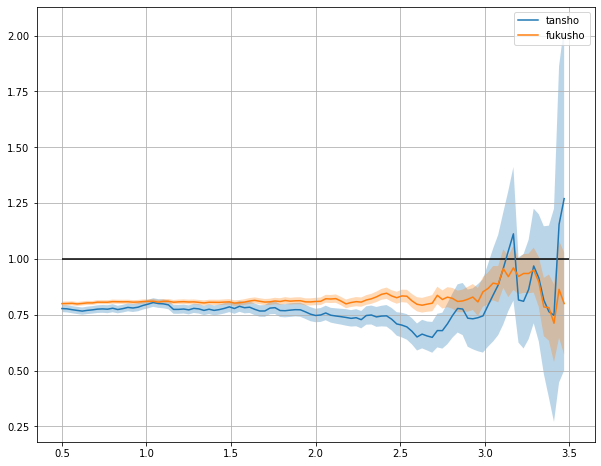

In [ ]:
plt.figure(figsize=(10, 8))
plot(g_tansho, 'tansho')
plot(g_fukusho, 'fukusho')
plt.hlines(1, xmin=0.5, xmax=3.5) # y=1の直線

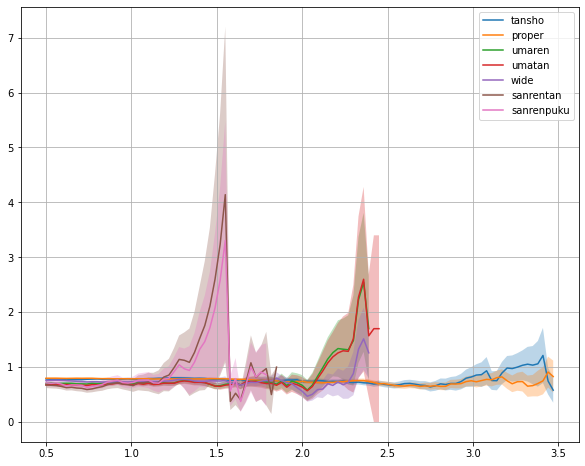

In [ ]:
# 横軸: 閾値
# 縦軸: 回収率

plt.figure(figsize=(10, 8))
plot(g_tansho, 'tansho')
plot(g_proper, 'proper')
plot(g_umaren, 'umaren')
plot(g_umatan, 'umatan')
plot(g_wide, 'wide')
plot(g_sanrentan, 'sanrentan')
plot(g_sanrenpuku, 'sanrenpuku')

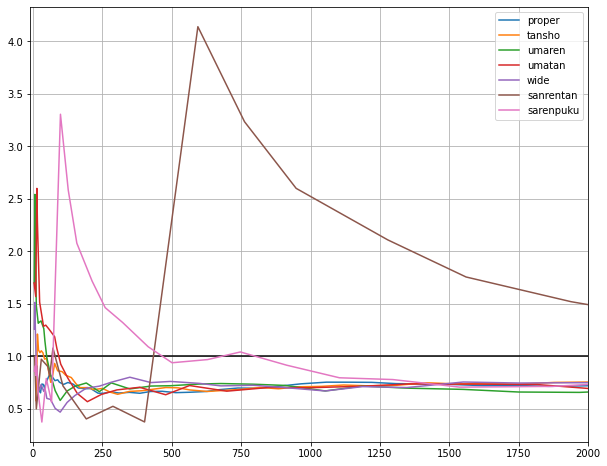

In [ ]:
# 横軸: 賭け枚数
# 縦軸: 回収率
# 賭け枚数が少ない→一つの当たりの影響が大きい→賭け枚数が多いところでの期待値も＋になることが理想。

plt.figure(figsize=(10, 8))
plt.plot(g_proper['n_bets'], g_proper['return_rate'], label='proper')
plt.plot(g_tansho['n_bets'], g_tansho['return_rate'], label='tansho')
plt.plot(g_umaren['n_bets'], g_umaren['return_rate'], label='umaren')
plt.plot(g_umatan['n_bets'], g_umatan['return_rate'], label='umatan')
plt.plot(g_wide['n_bets'], g_wide['return_rate'], label='wide')
plt.plot(g_sanrentan['n_bets'], g_sanrentan['return_rate'], label='sanrentan')
plt.plot(g_sanrenpuku['n_bets'], g_sanrenpuku['return_rate'], label='sarenpuku')
plt.hlines(1, xmin=-10, xmax=2000) # y=1の直線
plt.xlim(-10, 2000)
plt.legend()
plt.grid(True)

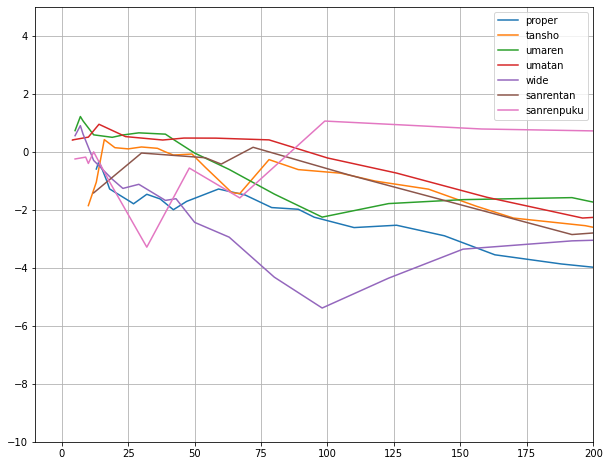

In [ ]:
# シャープレシオ

plt.figure(figsize=(10, 8))
plt.plot(g_proper['n_bets'], (g_proper['return_rate'] - 1) / g_proper['std'], label='proper')
plt.plot(g_tansho['n_bets'], (g_tansho['return_rate'] - 1) / g_tansho['std'], label='tansho')
plt.plot(g_umaren['n_bets'], (g_umaren['return_rate'] - 1) / g_umaren['std'], label='umaren')
plt.plot(g_umatan['n_bets'], (g_umatan['return_rate'] - 1) / g_umatan['std'], label='umatan')
plt.plot(g_wide['n_bets'], (g_wide['return_rate'] - 1) / g_wide['std'], label='wide')
plt.plot(g_sanrentan['n_bets'], (g_sanrentan['return_rate'] - 1) / g_sanrentan['std'], label='sanrentan')
plt.plot(g_sanrenpuku['n_bets'], (g_sanrenpuku['return_rate'] - 1) / g_sanrenpuku['std'], label='sanrenpuku')
plt.xlim(-10, 200)
plt.ylim(-10, 5)
plt.legend()
plt.grid()

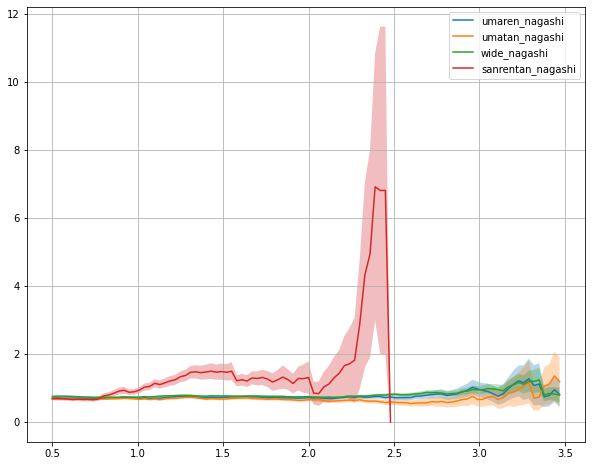

In [ ]:
# 横軸: 閾値
# 縦軸: 回収率

plt.figure(figsize=(10, 8))
plot(g_umaren_nagashi, 'umaren_nagashi')
plot(g_umatan_nagashi, 'umatan_nagashi')
plot(g_wide_nagashi, 'wide_nagashi')
plot(g_sanrentan_nagashi, 'sanrentan_nagashi')

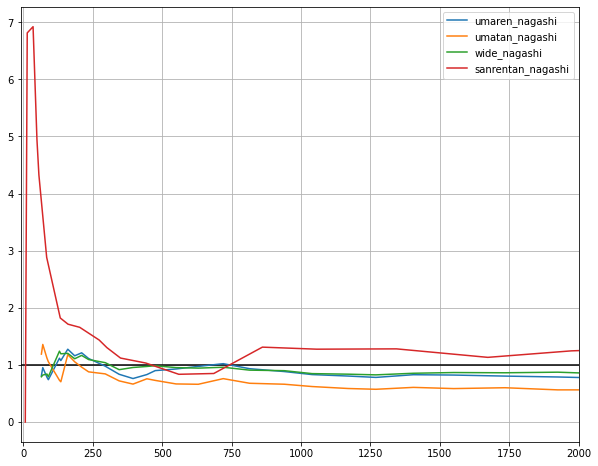

In [ ]:
# 横軸: 賭け枚数
# 縦軸: 回収率

plt.figure(figsize=(10, 8))
plt.plot(g_umaren_nagashi['n_bets'], g_umaren_nagashi['return_rate'], label='umaren_nagashi')
plt.plot(g_umatan_nagashi['n_bets'], g_umatan_nagashi['return_rate'], label='umatan_nagashi')
plt.plot(g_wide_nagashi['n_bets'], g_wide_nagashi['return_rate'], label='wide_nagashi')
plt.plot(g_sanrentan_nagashi['n_bets'], g_sanrentan_nagashi['return_rate'], label='sanrentan_nagashi')
plt.hlines(1, xmin=-10, xmax=2000) # y=1の直線
plt.xlim(-10, 2000)
plt.legend()
plt.grid(True)

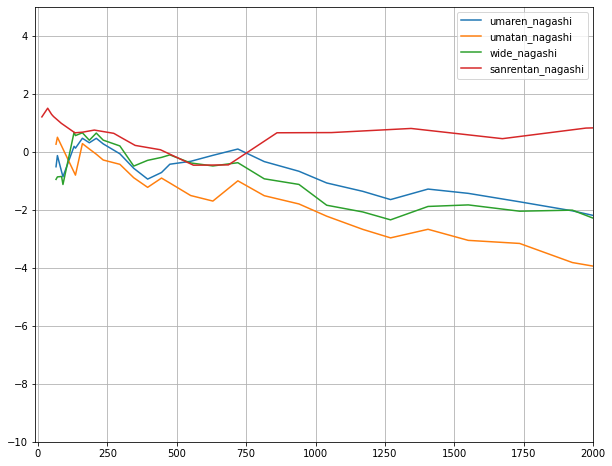

In [ ]:
# シャープレシオ

plt.figure(figsize=(10, 8))
plt.plot(g_umaren_nagashi['n_bets'], (g_umaren_nagashi['return_rate'] - 1) / g_umaren_nagashi['std'], label='umaren_nagashi')
plt.plot(g_umatan_nagashi['n_bets'], (g_umatan_nagashi['return_rate'] - 1) / g_umatan_nagashi['std'], label='umatan_nagashi')
plt.plot(g_wide_nagashi['n_bets'], (g_wide_nagashi['return_rate'] - 1) / g_wide_nagashi['std'], label='wide_nagashi')
plt.plot(g_sanrentan_nagashi['n_bets'], (g_sanrentan_nagashi['return_rate'] - 1) / g_sanrentan_nagashi['std'], label='sanrentan_nagashi')
plt.xlim(-10, 2000)
plt.ylim(-10, 5)
plt.legend()
plt.grid()

# 16: オブジェクト指向

## 16.1: classmethod

クラスのオブジェクトを作成したいときに、実行したい関数

In [ ]:
race_results=pd.read_pickle('drive/My Drive/Horse_racing/pickle/overall/race_results.pickle')

In [ ]:
r = RaceResults(race_results)

↓

In [ ]:
r = RaceResults.read_pickle(['drive/My Drive/Horse_racing/pickle/overall/race_results.pickle'])

## 16.2: staticmethod

クラス内の関数も通常の関数と同様に扱うことを可能とする。

In [ ]:
# scrape_race_results(['201901010101'])
# scrape_horse_results(horse_id_list)
# scrape_ped_results(horse_id_list)
# scrape_return_tables(race_id_list)

↓

In [ ]:
# Results.scrape(['201901010101'])
# HorseResults.scrape(horse_id_list)
# Peds.scrape(horse_id_list)
# Return.scrape(race_id_list)

# 17: 特長量追加

In [ ]:
horse_results

2017103879    2.2
2017103879    2.3
2017103879    0.7
2017103879    0.6
2017103879    0.4
             ... 
2013102815    0.4
2013102815    0.5
2013102815   -0.6
2013102815    0.5
2013102815    0.9
Name: 着差, Length: 261449, dtype: float64

In [ ]:
horse_results['着差'].map(lambda x: 0 if x<0 else x)

2017103879    2.2
2017103879    2.3
2017103879    0.7
2017103879    0.6
2017103879    0.4
             ... 
2013102815    0.4
2013102815    0.5
2013102815    0.0
2013102815    0.5
2013102815    0.9
Name: 着差, Length: 261449, dtype: float64

In [ ]:
horse_results['通過']

2017103879    12-12-12-12
2017103879        7-8-4-5
2017103879        2-2-1-1
2017103879            3-3
2017103879            2-2
                 ...     
2013102815            7-5
2013102815            5-5
2013102815            3-3
2013102815            2-2
2013102815            3-4
Name: 通過, Length: 261449, dtype: object

In [ ]:
re.findall(r'\d+', horse_results['通過'][0])[-1]

'12'

In [ ]:
horse_results['通過'].map(lambda x: corner(x))

2017103879    12.0
2017103879     5.0
2017103879     1.0
2017103879     3.0
2017103879     2.0
              ... 
2013102815     5.0
2013102815     5.0
2013102815     3.0
2013102815     2.0
2013102815     4.0
Name: 通過, Length: 261449, dtype: float64

In [ ]:
horse_results['通過'].map(lambda x:type(x)).value_counts()

<class 'str'>      258400
<class 'float'>      3049
Name: 通過, dtype: int64

In [ ]:
horse_results['通過'].isnull().sum()

3049

In [ ]:
r.data_h.head()

,枠番,馬番,斤量,course_len,weather,race_type,ground_state,date,horse_id,jockey_id,rank,性,年齢,体重,体重変化,着順_5R,賞金_5R,着順_9R,賞金_9R,着順_allR,賞金_allR
201901010101,1,1,54.0,1800,曇,芝,良,2019-07-27,2017105318,05339,1,牡,2,518,-16,3.0,180.0,3.0,180.0,3.0,180.0
201901010101,3,3,54.0,1800,曇,芝,良,2019-07-27,2017104612,05203,1,牡,2,496,-8,2.0,280.0,2.0,280.0,2.0,280.0
201901010101,4,4,51.0,1800,曇,芝,良,2019-07-27,2017103879,01180,1,牡,2,546,6,10.0,0.0,10.0,0.0,10.0,0.0
201901010101,8,9,51.0,1800,曇,芝,良,2019-07-27,2017106259,01179,0,牡,2,458,-8,4.0,110.0,4.0,110.0,4.0,110.0
201901010101,5,5,54.0,1800,曇,芝,良,2019-07-27,2017104140,01062,0,牡,2,436,0,9.0,0.0,9.0,0.0,9.0,0.0


In [ ]:
return_tables.index

Index(['201906040103', '201906040103', '201906040103', '201906040103',
       '201906040103', '201906040103', '201906040103', '201906040102',
       '201906040102', '201906040102',
       ...
       '202009060804', '202009060804', '202009060805', '202009060805',
       '202009060805', '202009060805', '202009060805', '202009060805',
       '202009060805', '202009060805'],
      dtype='object', length=16482)

In [ ]:
race_results.index

Index(['201901010101', '201901010101', '201901010101', '201901010101',
       '201901010101', '201901010101', '201901010101', '201901010101',
       '201901010101', '201901010102',
       ...
       '202010020812', '202010020812', '202010020812', '202010020812',
       '202010020812', '202010020812', '202010020812', '202010020812',
       '202010020812', '202010020812'],
      dtype='object', length=95856)